In [1]:
import os
import time

import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import lightgbm as lgb
import shap
import pickle
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, \
    accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Cấu hình chung
# plt.style.use('seaborn-whitegrid')
# sns.set_palette('Set2')
# %matplotlib inline

## 1. Data Loading

In [3]:
path = 'data/loan.csv'
df = pd.read_csv(path)
df.head()

C:\Users\PC\AppData\Local\Temp\ipykernel_21328\2938650306.py:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  1077501    1296599       5000         5000           4975.0   36 months   
1  1077430    1314167       2500         2500           2500.0   60 months   
2  1077175    1313524       2400         2400           2400.0   36 months   
3  1076863    1277178      10000        10000          10000.0   36 months   
4  1075358    1311748       3000         3000           3000.0   60 months   

  int_rate  installment grade sub_grade  ... num_tl_90g_dpd_24m  \
0   10.65%       162.87     B        B2  ...                NaN   
1   15.27%        59.83     C        C4  ...                NaN   
2   15.96%        84.33     C        C5  ...                NaN   
3   13.49%       339.31     C        C1  ...                NaN   
4   12.69%        67.79     B        B5  ...                NaN   

  num_tl_op_past_12m pct_tl_nvr_dlq  percent_bc_gt_75 pub_rec_bankruptcies  \
0                NaN            NaN               NaN                  0.0   
1                NaN            NaN               NaN                  0.0   
2                NaN            NaN               NaN                  0.0   
3                NaN            NaN               NaN                  0.0   
4                NaN            NaN               NaN                  0.0   

  tax_liens tot_hi_cred_lim total_bal_ex_mort total_bc_limit  \
0       0.0             NaN               NaN            NaN   
1       0.0             NaN               NaN            NaN   
2       0.0             NaN               NaN            NaN   
3       0.0             NaN               NaN            NaN   
4       0.0             NaN               NaN            NaN   

  total_il_high_credit_limit  
0                        NaN  
1                        NaN  
2                        NaN  
3                        NaN  
4                        NaN  

[5 rows x 111 columns]

## 2. Data Understanding & Cleaning

### Data Exploratory

In [4]:
def check_df(dataframe, head=5):
    print(" SHAPE ".center(70, '-'))
    print('Rows: {}'.format(dataframe.shape[0]))
    print('Columns: {}'.format(dataframe.shape[1]))
    print(" TYPES ".center(70, '-'))
    print(dataframe.dtypes)
    print(" HEAD ".center(70, '-'))
    print(dataframe.head(head))
    print(' TAIL '.center(70, '-'))
    print(dataframe.tail(head))
    print(' MISSING VALUES '.center(70, '-'))
    print(dataframe.isnull().sum())
    print(' DUPLICATED VALUES '.center(70, '-'))
    print(dataframe.duplicated().sum())


check_df(df)

------------------------------- SHAPE --------------------------------
Rows: 39717
Columns: 111
------------------------------- TYPES --------------------------------
id                              int64
member_id                       int64
loan_amnt                       int64
funded_amnt                     int64
funded_amnt_inv               float64
                               ...   
tax_liens                     float64
tot_hi_cred_lim               float64
total_bal_ex_mort             float64
total_bc_limit                float64
total_il_high_credit_limit    float64
Length: 111, dtype: object
-------------------------------- HEAD --------------------------------
        id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  1077501    1296599       5000         5000           4975.0   36 months   
1  1077430    1314167       2500         2500           2500.0   60 months   
2  1077175    1313524       2400         2400           2400.0   36 months   
3  10

In [5]:
def grab_col_names(dataframe, cat_th=5, car_th=10):
    # Threshold for the number of unique values to be considered a categorical (cat) or high-cardinality categorical (car) variable
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"# of Observations: {dataframe.shape[0]}")
    print(f"# of Features: {dataframe.shape[1]}")
    print(f'# of Categorical Columns: {len(cat_cols)}\t(Numerical but categorical: {len(num_but_cat)})')
    print(f'# of Numerical Columns: {len(num_cols)}')
    print(f'# of Categorical but cardinal: {len(cat_but_car)}')

    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=10)
print("\nCategorical:", cat_cols)
print("Numerical:", num_cols)
print("Categorical but cardinal:", cat_but_car)

# of Observations: 39717
# of Features: 111
# of Categorical Columns: 70	(Numerical but categorical: 61)
# of Numerical Columns: 26
# of Categorical but cardinal: 15

Categorical: ['term', 'grade', 'home_ownership', 'verification_status', 'loan_status', 'pymnt_plan', 'initial_list_status', 'next_pymnt_d', 'application_type', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


In [7]:
missing_features = 0
for column in df.columns:
    if df[column].isnull().sum() > 0:
        missing_features += 1

print('Features that have missing values:', missing_features)

Features that have missing values: 68


**Initial Observations:**
*  The dataset contains 39,717 observations, with 110 feature variables and 1 target variable `loan_status`.

*  Among the 110 feature variables, 68 have missing values. Due to the large amount of missing data, these variables need to be handled carefully to avoid significant information loss.

*  The dataset includes 70 categorical variables and 24 variables with data type "object" (string). If we want to use these variables with traditional models such as Logistic Regression, they will need to be properly processed and encoded.

### Data Cleaning

#### Remove unused features

**Remove Entity Features**

In [8]:
print("'id' unique values:", df['id'].nunique())
print("'member_id' unique values:", df['member_id'].nunique())

'id' unique values: 39717
'member_id' unique values: 39717


**Initial Observations:**

Since `id` and `member_id` have a number of unique values equal to the number of observations, both of these variables are Entity Features. Additionally, this dataset is not time-series data (as the observations are not temporally related — each observation belongs to a unique individual at a single point in time).

⇒ We can drop these Entity Features as they bring no additional infomation for the models.

In [9]:
df.drop(['id', 'member_id'], axis=1, inplace=True)

**Remove meaningless features.**

In [10]:
print("# of Unique values of Categorical features:", df[cat_cols].nunique().sort_values().unique())

# of Unique values of Categorical features: [0 1 2 3 5 7]


**Initial Observations:**

We can see that some features contain only 0 or 1 unique value, which means they don't provide any useful information for the model. Therefore, we will remove them.

In [11]:
for column in df.columns:
    if df[column].nunique() < 2:
        df.drop([column], axis=1, inplace=True)

**Remove irrelevant features.**

In [12]:
df['url'].value_counts()

url
https://lendingclub.com/browse/loanDetail.action?loan_id=87023      1
https://lendingclub.com/browse/loanDetail.action?loan_id=1077501    1
https://lendingclub.com/browse/loanDetail.action?loan_id=1077430    1
https://lendingclub.com/browse/loanDetail.action?loan_id=1077175    1
https://lendingclub.com/browse/loanDetail.action?loan_id=1076863    1
                                                                   ..
https://lendingclub.com/browse/loanDetail.action?loan_id=1071570    1
https://lendingclub.com/browse/loanDetail.action?loan_id=1071795    1
https://lendingclub.com/browse/loanDetail.action?loan_id=1072053    1
https://lendingclub.com/browse/loanDetail.action?loan_id=1069639    1
https://lendingclub.com/browse/loanDetail.action?loan_id=1075269    1
Name: count, Length: 39717, dtype: int64

In [13]:
df['desc'].value_counts()

desc
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             210
Debt Consolidation                                                                                                                                                                                                                                                                                                                                                

In [14]:
df['title'].value_counts()

title
Debt Consolidation            2184
Debt Consolidation Loan       1729
Personal Loan                  659
Consolidation                  517
debt consolidation             505
                              ... 
hardwood flooring business       1
DebtFix                          1
Credit card repayment loan       1
Brown Eyes Loan                  1
citicard fund                    1
Name: count, Length: 19615, dtype: int64

**Initial Observations:**

The features `desc` and `title` represent the loan application description and title, respectively. Both contain personal reasons for applying for a loan and are often written differently by each individual. Since we already have the `purpose` variable — which categorizes loan purposes in a standardized, more usable format — these 2 variables can be considered redundant and will be removed.

In [15]:
dropping_columns = ['url', 'desc', 'title']

for column in dropping_columns:
    df.drop([column], axis=1, inplace=True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 43 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   loan_amnt                39717 non-null  int64  
 1   funded_amnt              39717 non-null  int64  
 2   funded_amnt_inv          39717 non-null  float64
 3   term                     39717 non-null  object 
 4   int_rate                 39717 non-null  object 
 5   installment              39717 non-null  float64
 6   grade                    39717 non-null  object 
 7   sub_grade                39717 non-null  object 
 8   emp_title                37258 non-null  object 
 9   emp_length               38642 non-null  object 
 10  home_ownership           39717 non-null  object 
 11  annual_inc               39717 non-null  float64
 12  verification_status      39717 non-null  object 
 13  issue_d                  39717 non-null  object 
 14  loan_status           

#### Data type conversion

**From object (string) to float.**

In [17]:
print("Data type:", df['int_rate'].dtype)
df['int_rate'].value_counts()

Data type: object


int_rate
10.99%    956
13.49%    826
11.49%    825
7.51%     787
7.88%     725
         ... 
17.34%      1
16.71%      1
16.15%      1
18.36%      1
14.67%      1
Name: count, Length: 371, dtype: int64

In [18]:
print("Data type:", df['revol_util'].dtype)
df['revol_util'].value_counts()

Data type: object


revol_util
0%        977
0.20%      63
63%        62
40.70%     58
66.70%     58
         ... 
0.75%       1
2.64%       1
81.31%      1
26.33%      1
7.28%       1
Name: count, Length: 1089, dtype: int64

**Initial Observations:**

*  Both `int_rate` and `revol_util` contain numerical values but are stored as strings (object type), so we will convert them to float data type.


In [19]:
for column in ['int_rate', 'revol_util']:
    df[column] = df[column].str.rstrip('%').astype(float)
    df[column] /= 100

In [20]:
df['int_rate'].head()

0    0.1065
1    0.1527
2    0.1596
3    0.1349
4    0.1269
Name: int_rate, dtype: float64

In [21]:
df['revol_util'].head()

0    0.837
1    0.094
2    0.985
3    0.210
4    0.539
Name: revol_util, dtype: float64

**From object (string) to datetime.**

In [22]:
print("Data type:", df['issue_d'].dtype)
df['issue_d'].value_counts()

Data type: object


issue_d
Dec-11    2260
Nov-11    2223
Oct-11    2114
Sep-11    2063
Aug-11    1928
Jul-11    1870
Jun-11    1827
May-11    1689
Apr-11    1562
Mar-11    1443
Jan-11    1380
Feb-11    1297
Dec-10    1267
Oct-10    1132
Nov-10    1121
Jul-10    1119
Sep-10    1086
Aug-10    1078
Jun-10    1029
May-10     920
Apr-10     827
Mar-10     737
Feb-10     627
Nov-09     602
Dec-09     598
Jan-10     589
Oct-09     545
Sep-09     449
Aug-09     408
Jul-09     374
Jun-09     356
May-09     319
Apr-09     290
Mar-09     276
Feb-09     260
Jan-09     239
Mar-08     236
Dec-08     223
Nov-08     184
Feb-08     174
Jan-08     171
Apr-08     155
Oct-08      96
Dec-07      85
Jul-08      83
Aug-08      71
May-08      71
Jun-08      66
Oct-07      47
Nov-07      37
Aug-07      33
Sep-08      32
Jul-07      30
Sep-07      18
Jun-07       1
Name: count, dtype: int64

In [23]:
print("Data type:", df['last_pymnt_d'].dtype)
df['last_pymnt_d'].value_counts()

Data type: object


last_pymnt_d
May-16    1256
Mar-13    1026
Dec-14     945
May-13     907
Feb-13     869
          ... 
Jun-08      10
Nov-08      10
Mar-08       5
Jan-08       4
Feb-08       1
Name: count, Length: 101, dtype: int64

In [24]:
print("Data type:", df['last_credit_pull_d'].dtype)
df['last_credit_pull_d'].value_counts()

Data type: object


last_credit_pull_d
May-16    10308
Apr-16     2547
Mar-16     1123
Feb-13      843
Feb-16      736
          ...  
May-08        1
Jun-08        1
Jul-08        1
May-07        1
Jul-07        1
Name: count, Length: 106, dtype: int64

In [25]:
print("Data type:", df['earliest_cr_line'].dtype)
df['earliest_cr_line'].value_counts()

Data type: object


earliest_cr_line
Nov-98    370
Oct-99    366
Dec-98    348
Oct-00    346
Dec-97    329
         ... 
Jul-64      1
Apr-66      1
Dec-66      1
Oct-68      1
Oct-74      1
Name: count, Length: 526, dtype: int64

**Initial Observations:**

*  The features `issue_d`, `last_pymnt_d`, `last_credit_pull_d`, and `earliest_cr_line` all contain datetime values in the format MMM-YY, but are currently stored as strings (object type), so we will convert them to datetime data type.


In [26]:
for column in ['earliest_cr_line', 'issue_d', 'last_pymnt_d', 'last_credit_pull_d']:
    df[column] = pd.to_datetime(df[column], format='%b-%y')
    df[column] = df[column].dt.to_period('M')
    df[f'{column}_year'] = df[column].dt.year
    df[f'{column}_month'] = df[column].dt.month

In [27]:
df[['earliest_cr_line', 'issue_d', 'last_pymnt_d', 'last_credit_pull_d']].head()

earliest_cr_line  issue_d last_pymnt_d last_credit_pull_d
0          1985-01  2011-12      2015-01            2016-05
1          1999-04  2011-12      2013-04            2013-09
2          2001-11  2011-12      2014-06            2016-05
3          1996-02  2011-12      2015-01            2016-04
4          1996-01  2011-12      2016-05            2016-05

In [28]:
date_df = pd.DataFrame()
for column in ['earliest_cr_line', 'issue_d', 'last_pymnt_d', 'last_credit_pull_d']:
    date_df[f'{column}_year'] = df[f'{column}_year']
    date_df[f'{column}_month'] = df[f'{column}_month']

date_df.head()

earliest_cr_line_year  earliest_cr_line_month  issue_d_year  issue_d_month  \
0                   1985                       1          2011             12   
1                   1999                       4          2011             12   
2                   2001                      11          2011             12   
3                   1996                       2          2011             12   
4                   1996                       1          2011             12   

   last_pymnt_d_year  last_pymnt_d_month  last_credit_pull_d_year  \
0               2015                   1                     2016   
1               2013                   4                     2013   
2               2014                   6                     2016   
3               2015                   1                     2016   
4               2016                   5                     2016   

   last_credit_pull_d_month  
0                         5  
1                         9  
2                         5  
3                         4  
4                         5

#### Processing categorical features

In [29]:
df['term'].value_counts()

term
36 months    29096
60 months    10621
Name: count, dtype: int64

In [30]:
df['verification_status'].value_counts()

verification_status
Not Verified       16921
Verified           12809
Source Verified     9987
Name: count, dtype: int64

In [31]:
df['home_ownership'].value_counts()

home_ownership
RENT        18899
MORTGAGE    17659
OWN          3058
OTHER          98
NONE            3
Name: count, dtype: int64

In [32]:
df['grade'].value_counts()

grade
B    12020
A    10085
C     8098
D     5307
E     2842
F     1049
G      316
Name: count, dtype: int64

In [33]:
df['sub_grade'].value_counts()

sub_grade
B3    2917
A4    2886
A5    2742
B5    2704
B4    2512
C1    2136
B2    2057
C2    2011
B1    1830
A3    1810
C3    1529
A2    1508
D2    1348
C4    1236
C5    1186
D3    1173
A1    1139
D4     981
D1     931
D5     874
E1     763
E2     656
E3     553
E4     454
E5     416
F1     329
F2     249
F3     185
F4     168
F5     118
G1     104
G2      78
G4      56
G3      48
G5      30
Name: count, dtype: int64

In [34]:
df['emp_length'].value_counts()

emp_length
10+ years    8879
< 1 year     4583
2 years      4388
3 years      4095
4 years      3436
5 years      3282
1 year       3240
6 years      2229
7 years      1773
8 years      1479
9 years      1258
Name: count, dtype: int64

In [35]:
df['emp_title'].value_counts()

emp_title
US Army                             134
Bank of America                     109
IBM                                  66
AT&T                                 59
Kaiser Permanente                    56
                                   ... 
Connection Inspection                 1
Rich Products Corporation             1
Archdiocese of Galveston Houston      1
Osram Sylvania                        1
AIR RESOURCES BOARD                   1
Name: count, Length: 28820, dtype: int64

In [36]:
df['purpose'].value_counts()

purpose
debt_consolidation    18641
credit_card            5130
other                  3993
home_improvement       2976
major_purchase         2187
small_business         1828
car                    1549
wedding                 947
medical                 693
moving                  583
vacation                381
house                   381
educational             325
renewable_energy        103
Name: count, dtype: int64

In [37]:
df['next_pymnt_d'].value_counts()

next_pymnt_d
Jun-16    1125
Jul-16      15
Name: count, dtype: int64

In [38]:
missing_values = df['next_pymnt_d'].isnull().sum()
print(f'# of missing values: {missing_values}/{df.shape[0]}')

# of missing values: 38577/39717


In [39]:
df['zip_code'].value_counts()

zip_code
100xx    597
945xx    545
112xx    516
606xx    503
070xx    473
        ... 
353xx      1
677xx      1
090xx      1
479xx      1
469xx      1
Name: count, Length: 823, dtype: int64

In [40]:
df['addr_state'].value_counts()

addr_state
CA    7099
NY    3812
FL    2866
TX    2727
NJ    1850
IL    1525
PA    1517
VA    1407
GA    1398
MA    1340
OH    1223
MD    1049
AZ     879
WA     840
CO     792
NC     788
CT     751
MI     720
MO     686
MN     615
NV     497
SC     472
WI     460
AL     452
OR     451
LA     436
KY     325
OK     299
KS     271
UT     258
AR     245
DC     214
RI     198
NM     189
WV     177
HI     174
NH     171
DE     114
MT      85
WY      83
AK      80
SD      64
VT      54
MS      19
TN      17
IN       9
ID       6
IA       5
NE       5
ME       3
Name: count, dtype: int64

**Initial Observations:**

*  The feature `term` has only 2 unique values, so we can encode it as 0 and 1.

*  The feature `verification_status` has 3 unique values, so we can apply one-hot encoding.

*  The feature `home_ownership` has 5 unique values, so we can apply one-hot encoding.

*  The features `grade` and `sub_grade` are both grading scales with different ranges. We can keep the `sub_grade` feature for label encoding (since integer values can represent an order, like a ranking) and remove the `grade` feature, as it conveys redundant information.

*  Similarly, the feature `emp_length` indicates the number of years of work experience, so we can apply label encoding (with 0 representing less than one year of experience).

*  The feature `emp_title` tells us the customer's occupation. This could provide a lot of information about the customer. However, it has 28,820 unique values, meaning we would need to group occupations into broader, more generalized categories to fit the model. This could take a long time and might not improve the model significantly, so we’ll choose to discard this feature to simplify the task for a project.

*  The `purpose` feature indicates the customer's reason for taking out a loan. However, this feature has quite a few unique values (13 in total), and the distribution among these values is highly imbalanced, with most of the data concentrated in the `debt_consolidation` category. There are several ways to handle this feature — one option is to apply one-hot encoding for each value — but that could complicate the computation. To keep things simpler for traditional machine learning models, we choose to reduce this feature to just 2 unique values: `debt_consolidation` (encoded as 1) and `not debt_consolidation` (encoded as 0).

*  Similarly, the feature `next_pymnt_d` indicates the next scheduled payment date of the customer. Therefore, we can encode the Null values as 'Unknown', representing an unscheduled payment. Afterward, we can reduce this feature to just 2 unique values: `scheduled payment` (encoded as 1) and `unscheduled payment` (encoded as 0).

*  The features `zip_code` and `addr_state` provide information about the applicant’s location. Therefore, we can group the zip codes into larger regions to encode the `addr_state` feature and discard the `zip_code` feature.

**Summary:**
*  Label encoding: `term`, `sub_grade`, `emp_length`, `purpose`,  `next_pymnt_d`

*  One-hot encoding: `verification_status`, `home_ownership`, `addr_state` (after grouping)

*  Remove: `grade`, `emp_title`, `zip_code`

**Label Encoding**

In [41]:
def label_encoder(dataframe, col):
    labelencoder = LabelEncoder()
    dataframe[col] = labelencoder.fit_transform(dataframe[col])
    return dataframe

In [42]:
label_encode_columns = ['term', 'sub_grade', 'emp_length']

for col in label_encode_columns:
    df = label_encoder(df, col)

In [43]:
df['term'].value_counts().sort_index()

term
0    29096
1    10621
Name: count, dtype: int64

In [44]:
df['sub_grade'].value_counts().sort_index()

sub_grade
0     1139
1     1508
2     1810
3     2886
4     2742
5     1830
6     2057
7     2917
8     2512
9     2704
10    2136
11    2011
12    1529
13    1236
14    1186
15     931
16    1348
17    1173
18     981
19     874
20     763
21     656
22     553
23     454
24     416
25     329
26     249
27     185
28     168
29     118
30     104
31      78
32      48
33      56
34      30
Name: count, dtype: int64

In [45]:
df['emp_length'].value_counts().sort_index()

emp_length
0     3240
1     8879
2     4388
3     4095
4     3436
5     3282
6     2229
7     1773
8     1479
9     1258
10    4583
11    1075
Name: count, dtype: int64

In [46]:
def process_purpose(value):
    if value == 'debt_consolidation':
        return 1
    else:
        return 0

df['purpose'] = df['purpose'].apply(process_purpose)
df['purpose'].value_counts().sort_index()

purpose
0    21076
1    18641
Name: count, dtype: int64

In [47]:
def process_next_pymnt_d(value):
    if value in ['Jun-16', 'Jul-16']:
        return 1
    else:
        return 0

df['next_pymnt_d'] = df['next_pymnt_d'].apply(process_next_pymnt_d)
df['next_pymnt_d'].value_counts().sort_index()

next_pymnt_d
0    38577
1     1140
Name: count, dtype: int64

Group the `addr_state` feature into larger regions to prepare for One-hot Encoding.

In [48]:
def categorize_state(state):
    northeast = ['CT', 'ME', 'MA', 'NH', 'NJ', 'NY', 'PA', 'RI', 'VT']
    midwest = ['IA', 'IL', 'IN', 'KS', 'MI',
               'MN', 'MO', 'NE', 'ND', 'OH', 'SD', 'WI']
    south = ['AL', 'AR', 'DC', 'DE', 'FL', 'GA', 'KY', 'LA',
             'MD', 'MS', 'NC', 'OK', 'SC', 'TN', 'TX', 'VA', 'WV']
    west = ['AK', 'AZ', 'CA', 'CO', 'HI', 'ID',
            'MT', 'NV', 'NM', 'OR', 'UT', 'WA', 'WY']

    if state in northeast:
        return 'Northeast'
    elif state in midwest:
        return 'Midwest'
    elif state in south:
        return 'South'
    elif state in west:
        return 'West'
    else:
        return 'Unknown'


df['region'] = df['addr_state'].apply(categorize_state)

In [49]:
df['region'].value_counts()

region
South        13005
West         11433
Northeast     9696
Midwest       5583
Name: count, dtype: int64

**One-hot Encoding**

In [50]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe,
                               columns=categorical_cols,
                               drop_first=drop_first,
                               dtype=int)
    return dataframe

In [51]:
onehot_encode_columns = ['verification_status', 'home_ownership', 'region']

df = one_hot_encoder(df, onehot_encode_columns)

In [52]:
df.head()

loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment grade  \
0       5000         5000           4975.0     0    0.1065       162.87     B   
1       2500         2500           2500.0     1    0.1527        59.83     C   
2       2400         2400           2400.0     0    0.1596        84.33     C   
3      10000        10000          10000.0     0    0.1349       339.31     C   
4       3000         3000           3000.0     1    0.1269        67.79     B   

   sub_grade                 emp_title  emp_length  ...  \
0          6                       NaN           1  ...   
1         13                     Ryder          10  ...   
2         14                       NaN           1  ...   
3         10       AIR RESOURCES BOARD           1  ...   
4          9  University Medical Group           0  ...   

   verification_status_Verified home_ownership_MORTGAGE home_ownership_NONE  \
0                             1                       0                   0   
1                             0                       0                   0   
2                             0                       0                   0   
3                             0                       0                   0   
4                             0                       0                   0   

   home_ownership_OTHER home_ownership_OWN home_ownership_RENT  \
0                     0                  0                   1   
1                     0                  0                   1   
2                     0                  0                   1   
3                     0                  0                   1   
4                     0                  0                   1   

   region_Midwest  region_Northeast region_South  region_West  
0               0                 0            0            1  
1               0                 0            1            0  
2               1                 0            0            0  
3               0                 0            0            1  
4               0                 0            0            1  

[5 rows x 61 columns]

**Remove unused features**

In [53]:
dropping_columns = ['grade', 'emp_title', 'zip_code', 'addr_state']

for column in dropping_columns:
    df.drop([column], axis=1, inplace=True)

In [54]:
df.head()

loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
0       5000         5000           4975.0     0    0.1065       162.87   
1       2500         2500           2500.0     1    0.1527        59.83   
2       2400         2400           2400.0     0    0.1596        84.33   
3      10000        10000          10000.0     0    0.1349       339.31   
4       3000         3000           3000.0     1    0.1269        67.79   

   sub_grade  emp_length  annual_inc  issue_d  ...  \
0          6           1     24000.0  2011-12  ...   
1         13          10     30000.0  2011-12  ...   
2         14           1     12252.0  2011-12  ...   
3         10           1     49200.0  2011-12  ...   
4          9           0     80000.0  2011-12  ...   

  verification_status_Verified  home_ownership_MORTGAGE  home_ownership_NONE  \
0                            1                        0                    0   
1                            0                        0                    0   
2                            0                        0                    0   
3                            0                        0                    0   
4                            0                        0                    0   

   home_ownership_OTHER home_ownership_OWN  home_ownership_RENT  \
0                     0                  0                    1   
1                     0                  0                    1   
2                     0                  0                    1   
3                     0                  0                    1   
4                     0                  0                    1   

   region_Midwest  region_Northeast  region_South  region_West  
0               0                 0             0            1  
1               0                 0             1            0  
2               1                 0             0            0  
3               0                 0             0            1  
4               0                 0             0            1  

[5 rows x 57 columns]

#### Handle Missing values

In [55]:
def check_missing_values(dataframe):
    print(" SHAPE ".center(70, '-'))
    print('Rows: {}'.format(dataframe.shape[0]))
    print('Columns: {}'.format(dataframe.shape[1]))
    print(' MISSING VALUES '.center(70, '-'))
    print(dataframe.isnull().sum())

check_missing_values(df)

------------------------------- SHAPE --------------------------------
Rows: 39717
Columns: 57
--------------------------- MISSING VALUES ---------------------------
loan_amnt                                  0
funded_amnt                                0
funded_amnt_inv                            0
term                                       0
int_rate                                   0
installment                                0
sub_grade                                  0
emp_length                                 0
annual_inc                                 0
issue_d                                    0
loan_status                                0
purpose                                    0
dti                                        0
delinq_2yrs                                0
earliest_cr_line                           0
inq_last_6mths                             0
mths_since_last_delinq                 25682
mths_since_last_record                 36931
open_acc                

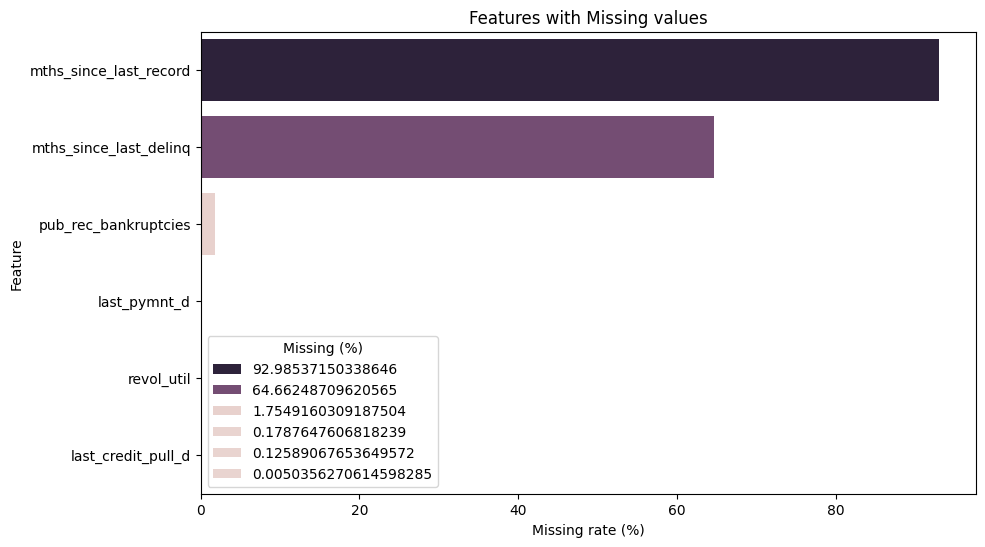

In [56]:
# Compute missing values percentage
missing_percent = df.isnull().mean().sort_values(ascending=False) * 100
missing_df = missing_percent[missing_percent > 0].to_frame().reset_index()
missing_df.columns = ['Feature', 'Missing (%)']

plt.figure(figsize=(10, 6))
sns.barplot(data=missing_df, x='Missing (%)', y='Feature', hue='Missing (%)')

# Reverse the legend order to match the bar order
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], title='Missing (%)')

plt.title('Features with Missing values')
plt.xlabel('Missing rate (%)')
plt.ylabel('Feature')
plt.show()

**Initial Observations:**

*  The features `mths_since_last_delinq` and `mths_since_last_record` have **64.66%** and **92.99%** missing data, respectively. Additionally, since both are numerical features, we cannot handle them the same way we did with categorical features earlier. Therefore, we can choose to remove these features.

*  The features `last_credit_pull_d`, `revol_util`, `last_pymnt_d`, and `pub_rec_bankruptcies` have relatively few missing values — approximately ~0%, 0.13%, 0.18% and 1.75%, respectively — so we can drop those observations without significantly affecting the overall data distribution.

In [57]:
df.drop(['mths_since_last_delinq', 'mths_since_last_record'], axis=1, inplace=True)

In [58]:
df = df.dropna()

In [59]:
check_missing_values(df)

------------------------------- SHAPE --------------------------------
Rows: 38902
Columns: 55
--------------------------- MISSING VALUES ---------------------------
loan_amnt                              0
funded_amnt                            0
funded_amnt_inv                        0
term                                   0
int_rate                               0
installment                            0
sub_grade                              0
emp_length                             0
annual_inc                             0
issue_d                                0
loan_status                            0
purpose                                0
dti                                    0
delinq_2yrs                            0
earliest_cr_line                       0
inq_last_6mths                         0
open_acc                               0
pub_rec                                0
revol_bal                              0
revol_util                             0
total_acc     

In [60]:
print(' DUPLICATED VALUES '.center(70, '-'))
print(df.duplicated().sum())

------------------------- DUPLICATED VALUES --------------------------
0


**Initial Observations:**

The dataset no longer contains any missing values or duplicated observations. In addition, irrelevant features have been removed, categorical and datetime features have been processed, and outliers have been handled.

⇒ We can now begin using the dataset for analysis and model training.

## 3. Exploratory Data Analysis (EDA)

#### Check the distribution of the target feature - `loan_status`

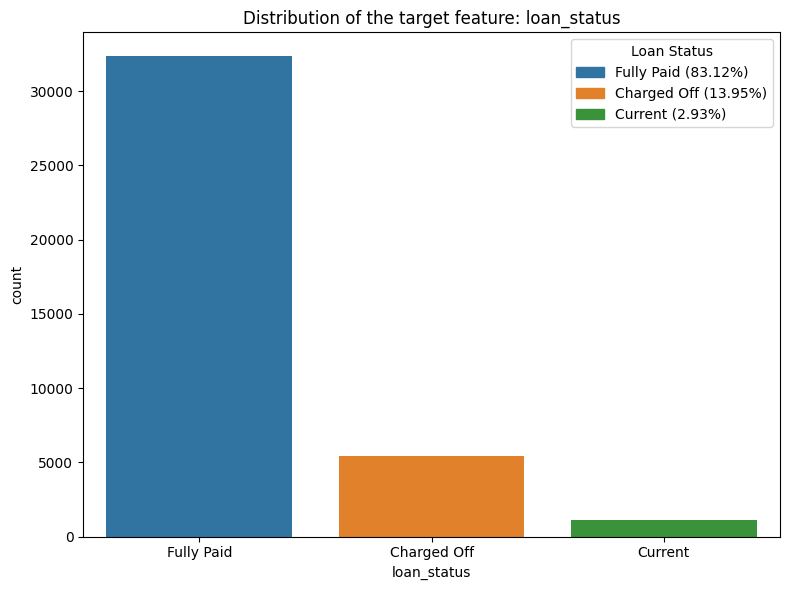

In [61]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='loan_status', hue='loan_status', legend=False)

# Create handles (use the bars' colors) and labels
target_classes = df['loan_status'].unique()
percentages = df['loan_status'].value_counts(normalize=True).loc[target_classes] * 100
handles = [plt.Rectangle((0,0),1,1, color=bar.get_facecolor()) for bar in ax.patches]
labels = [f"{cls} ({percentages[cls]:.2f}%)" for cls in target_classes]

plt.legend(handles, labels, title='Loan Status')
plt.title('Distribution of the target feature: loan_status')
plt.tight_layout()
plt.show()

**Initial Observations:**

The target feature `loan_status` has 3 values:

*  `Fully Paid`: The borrower has repaid the full loan amount, including principal and interest, according to the loan terms.

*  `Current`: The borrower is currently making payments on time.

*  `Charged Off`: The borrower has defaulted for an extended period, and the lender has written off the debt as uncollectible.

⇒ Since we aim to build a model that classifies whether a customer should or should not be approved for a loan, we will group those with good repayment behavior — `Fully Paid` and `Current` — into the `Accept` group (i.e., eligible for a loan), and those with poor repayment behavior — `Charged Off` — into the `Reject` group (i.e., ineligible for a loan).

⇒ We will encode `Accept` as 1 and `Reject` as 0.

**Regarding imbalanced data:**
There is an imbalance between the classes, which could cause one class to dominate the model. However, we will first try building the models to see if this imbalance causes any performance issues. If it does, we’ll apply techniques to address it. If the model performs well without signs of class dominance, we can skip handling the imbalance.

In [62]:
df['loan_status'] = df['loan_status'].apply(
    lambda x: 1 if (x == 'Fully Paid' or x == 'Current') else 0)

In [63]:
df['loan_status'].value_counts()

loan_status
1    33477
0     5425
Name: count, dtype: int64

#### Univariate Analysis

In [64]:
numeric_df = df.select_dtypes(include=[np.number])  # Sort out period and object features
numeric_df = numeric_df.drop(columns=['loan_status'])
cat_cols, num_cols, cat_but_car = grab_col_names(numeric_df, cat_th=5, car_th=10)

# of Observations: 38902
# of Features: 50
# of Categorical Columns: 16	(Numerical but categorical: 16)
# of Numerical Columns: 34
# of Categorical but cardinal: 0


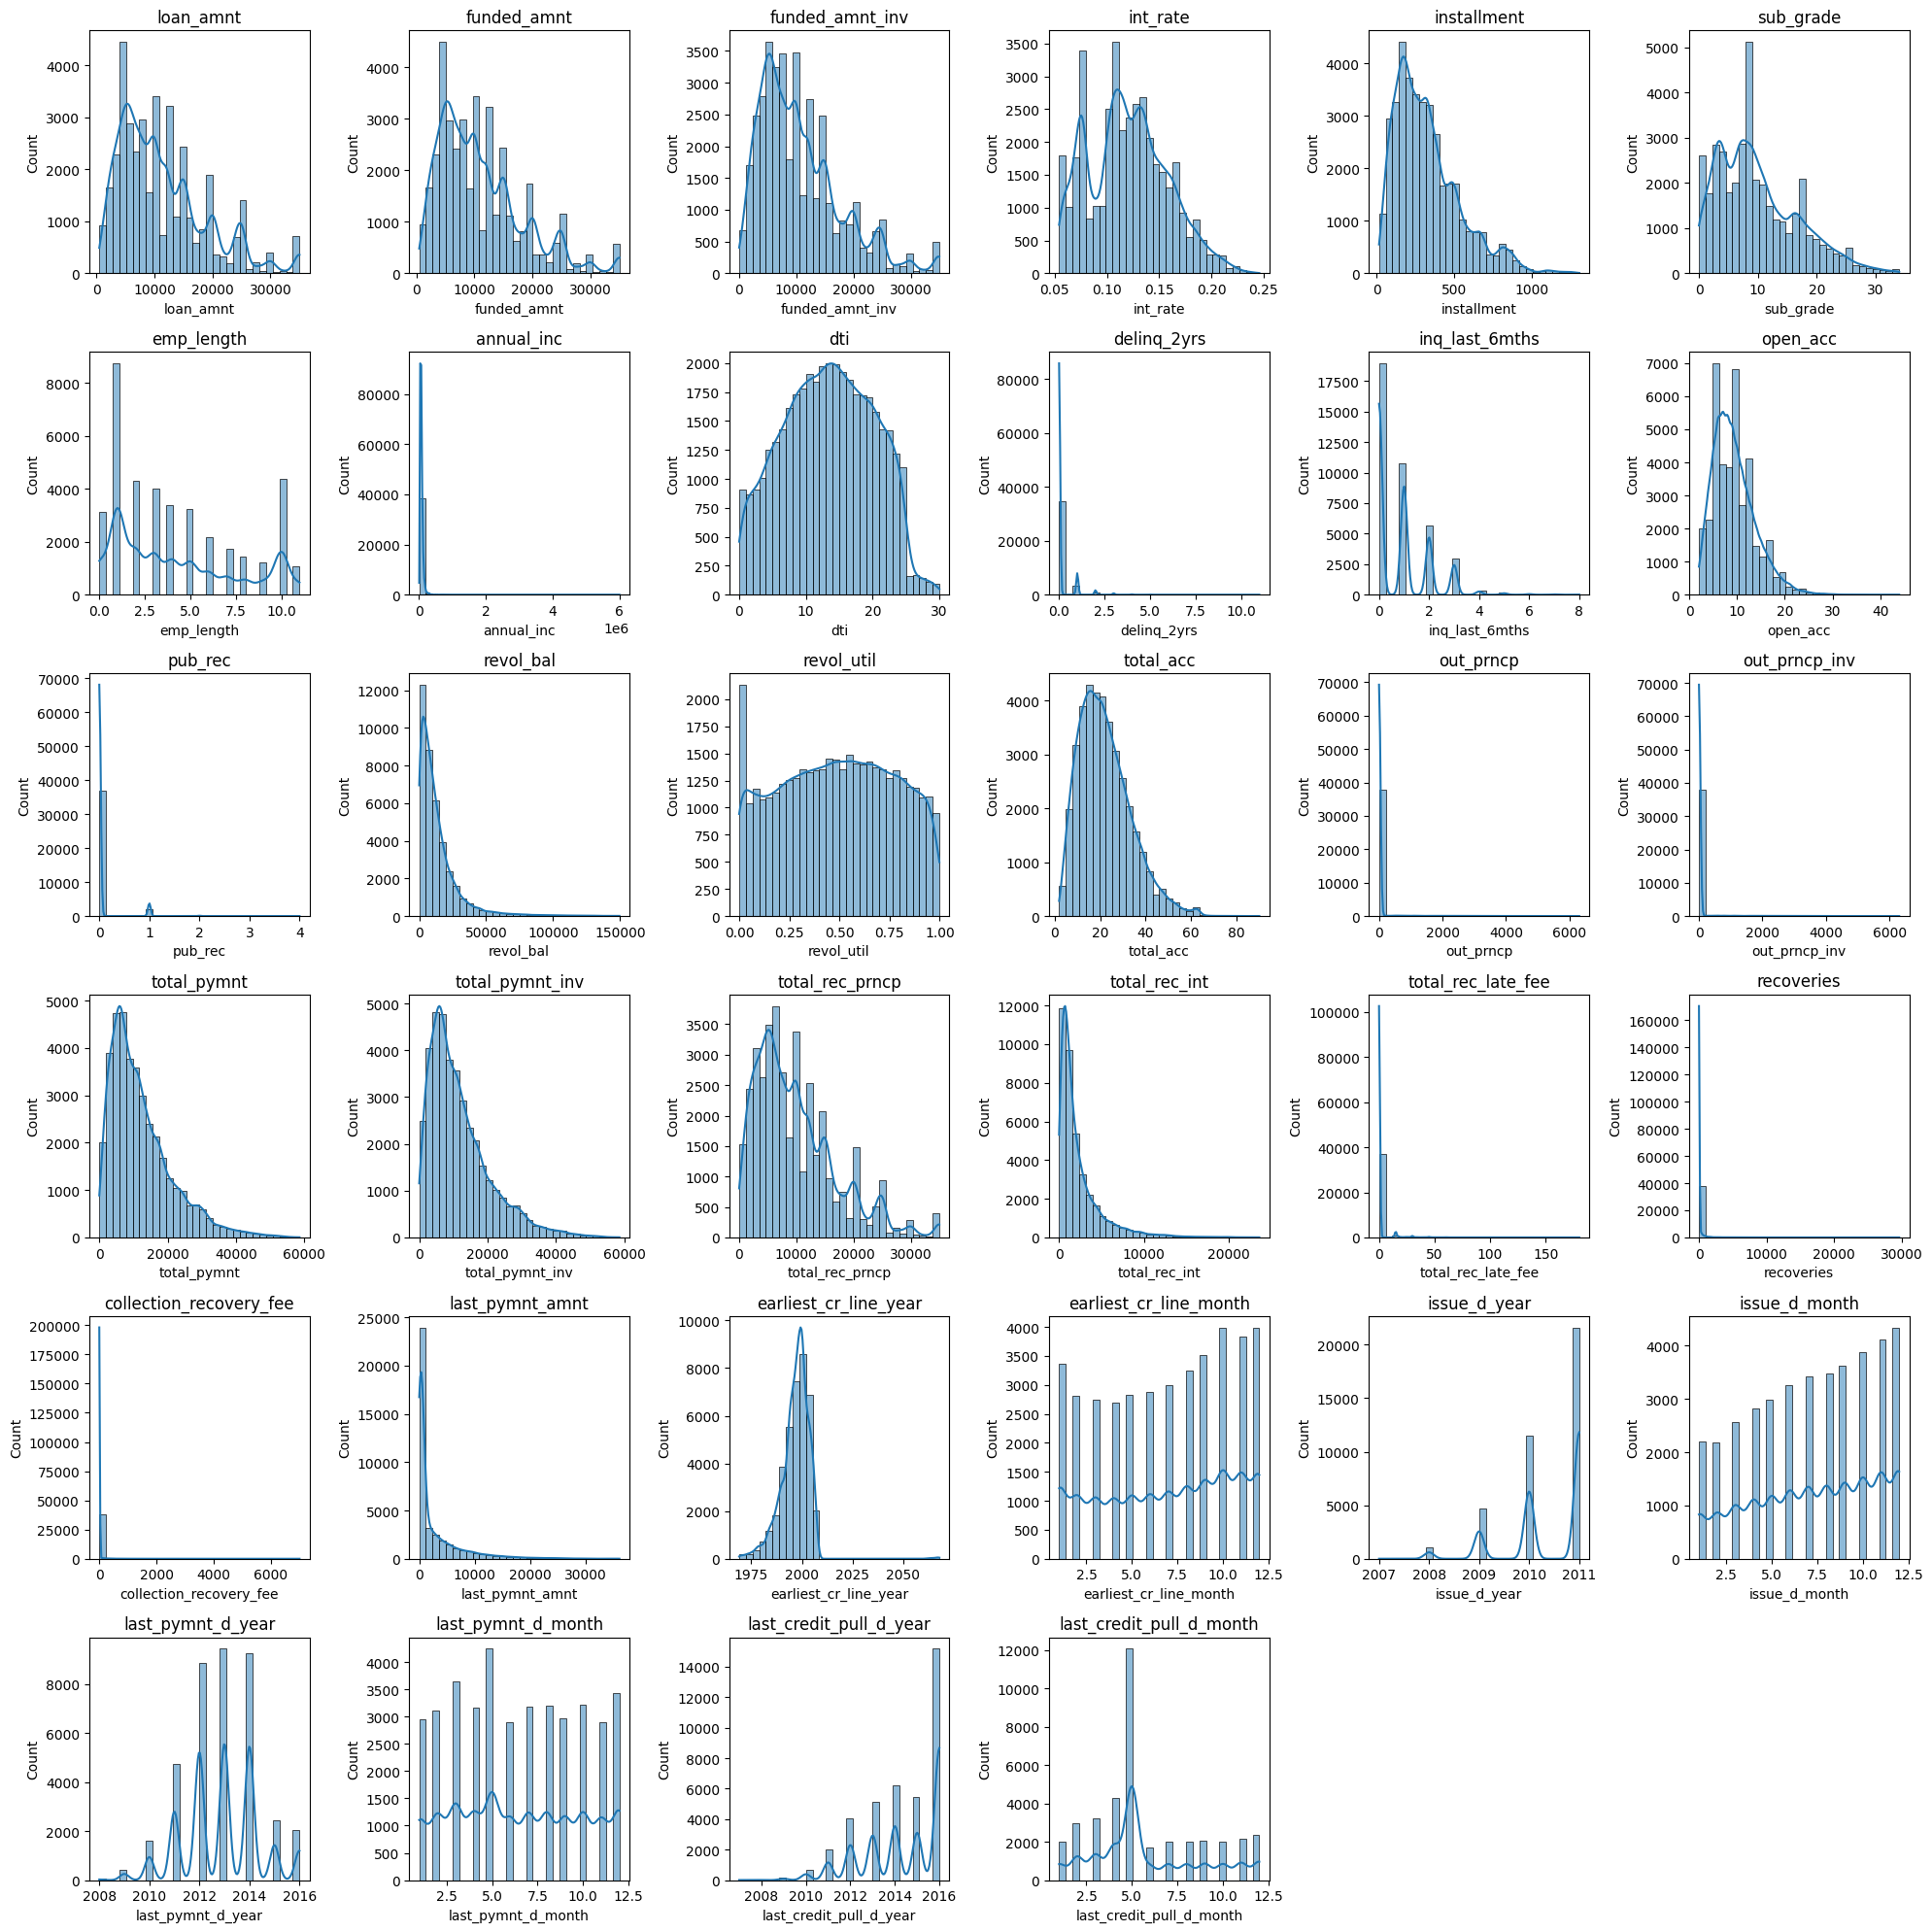

In [65]:
def plot_distributions(df, columns, cols=3, figsize=(20, 20), kind='hist'):
    rows = -(-len(columns) // cols)  # ceiling division
    plt.figure(figsize=figsize)
    for i, col in enumerate(columns, 1):
        plt.subplot(rows, cols, i)
        if kind == 'hist':
            sns.histplot(df[col], kde=True, bins=30)
        elif kind == 'box':
            sns.boxplot(x=df[col])
        elif kind == 'count':
            sns.countplot(x=df[col], order=df[col].value_counts().index)
            plt.xticks(rotation=90)
        plt.title(col)
    plt.tight_layout()
    plt.show()

plot_distributions(numeric_df, num_cols, kind='hist', cols=6, figsize=(20, 20))

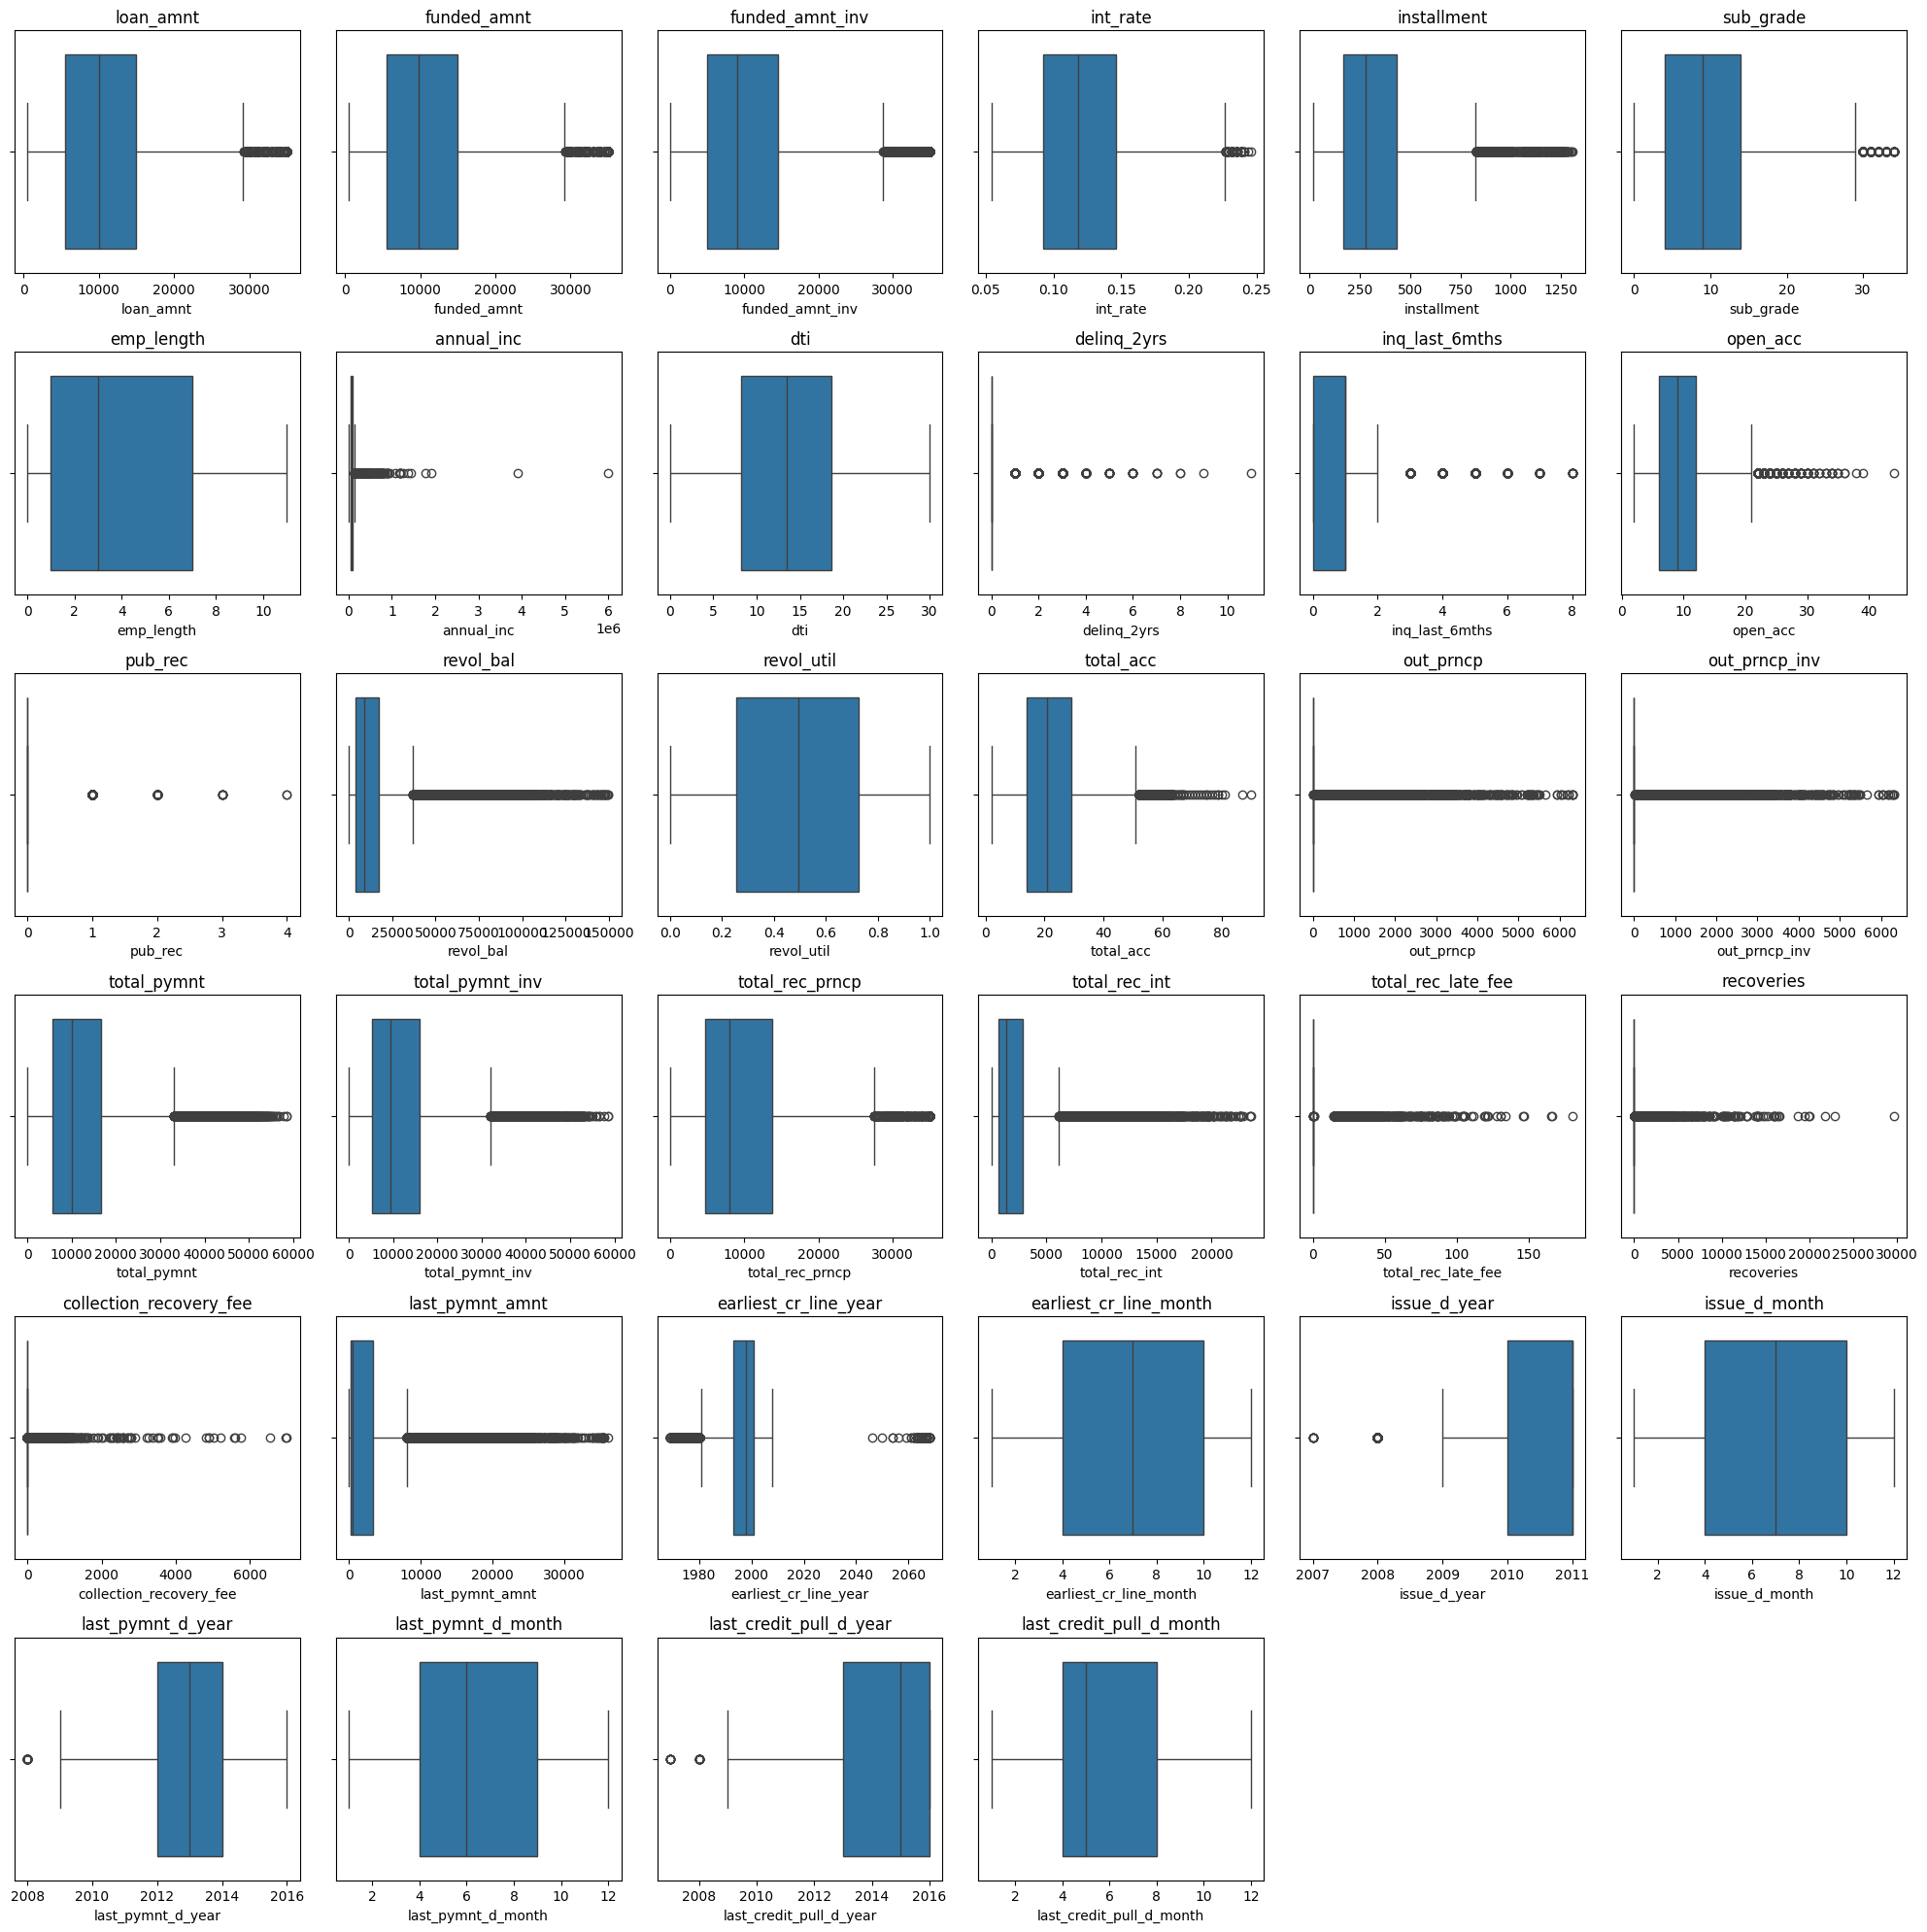

In [66]:
plot_distributions(numeric_df, num_cols, kind='box', cols=6, figsize=(20, 20))

**Initial Observations:**

Many features are heavily skewed, which is a sign that there may be outliers in the dataset. However, we cannot rely solely on the individual distribution of each feature to remove outliers using methods like IQR or Z-score, as these approaches do not take into account interactions between multiple features. Removing outliers this way may unintentionally eliminate meaningful outliers relevant to the problem, or even remove too many observations, leading to significant data loss.

⇒ Therefore, we need an outlier detection method that considers the combination of multiple features.

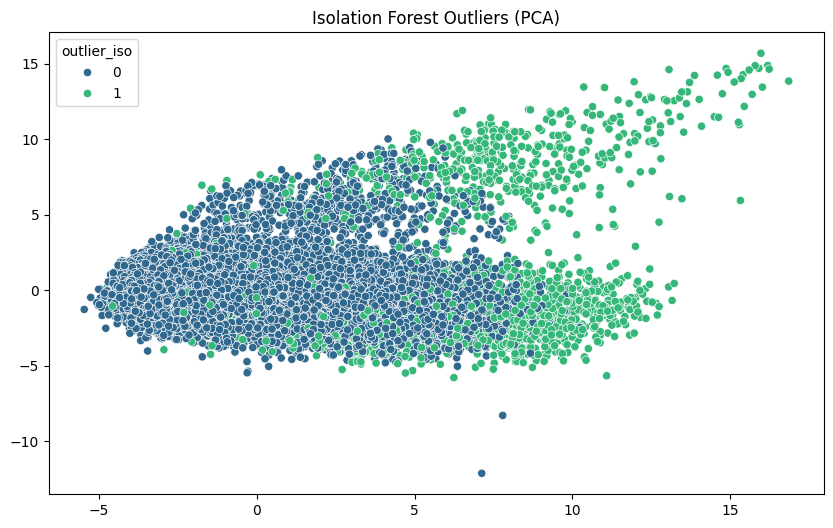

In [398]:
from sklearn.ensemble import IsolationForest

# Load and preprocess data (replace with your data)
X = numeric_df
iso_df = df.copy()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=0)  # Adjust contamination
outliers_iso = iso_forest.fit_predict(X_scaled)

# Flag outliers (-1 for outliers, 1 for inliers)
iso_df['outlier_iso'] = np.where(outliers_iso == -1, 1, 0)

# Visualize outliers in 3D using PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=iso_df['outlier_iso'], palette='viridis')
plt.title('Isolation Forest Outliers (PCA)')
plt.show()

In [399]:
iso_df['outlier_iso'].value_counts()

outlier_iso
0    36956
1     1946
Name: count, dtype: int64

In [400]:
iso_df = iso_df[iso_df['outlier_iso'] != 1]
iso_df.reset_index(drop=True, inplace=True)

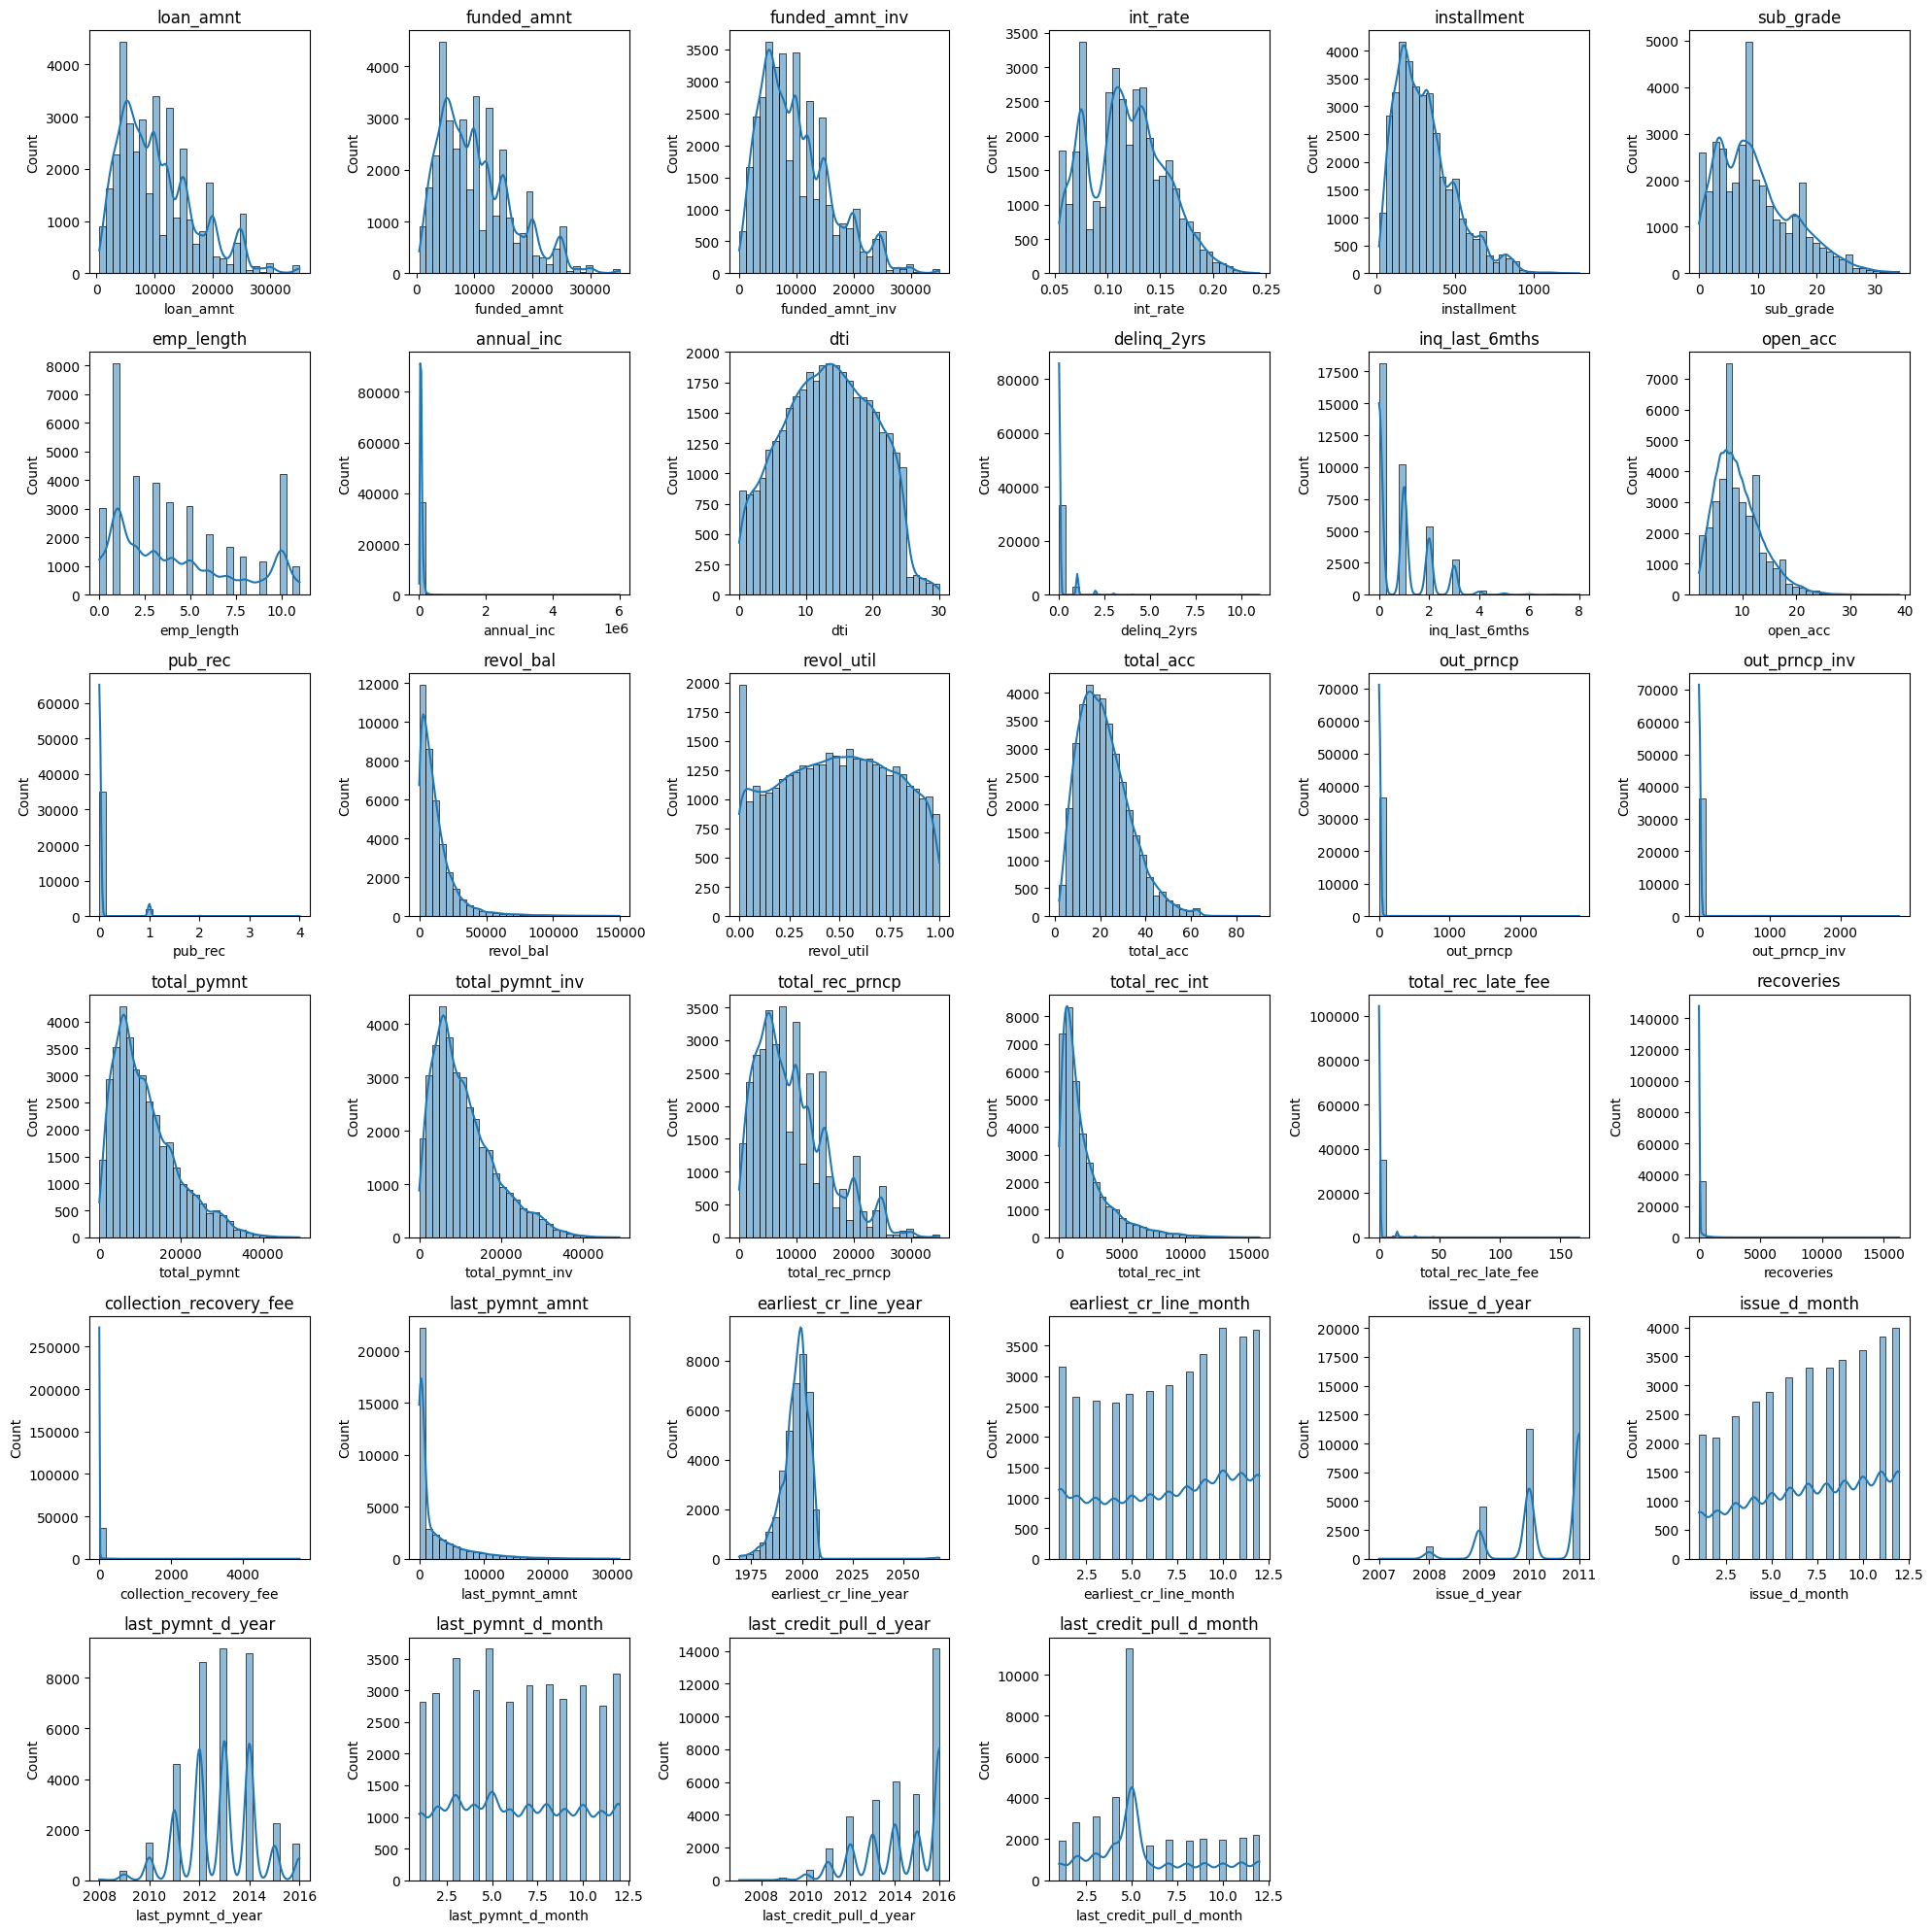

In [401]:
plot_distributions(iso_df, num_cols, kind='hist', cols=6, figsize=(20, 20))

In [402]:
numerical_features = iso_df.select_dtypes(include=[np.number]).drop(columns=['loan_status', 'outlier_iso'])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_features)
pca = PCA(n_components=3)
principal_components = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
pca_df['loan_status'] = iso_df['loan_status'].values

In [403]:
fig = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3', color='loan_status',
                    title='PCA 3D Scatter Plot of Loan Status Classes')

fig.show()

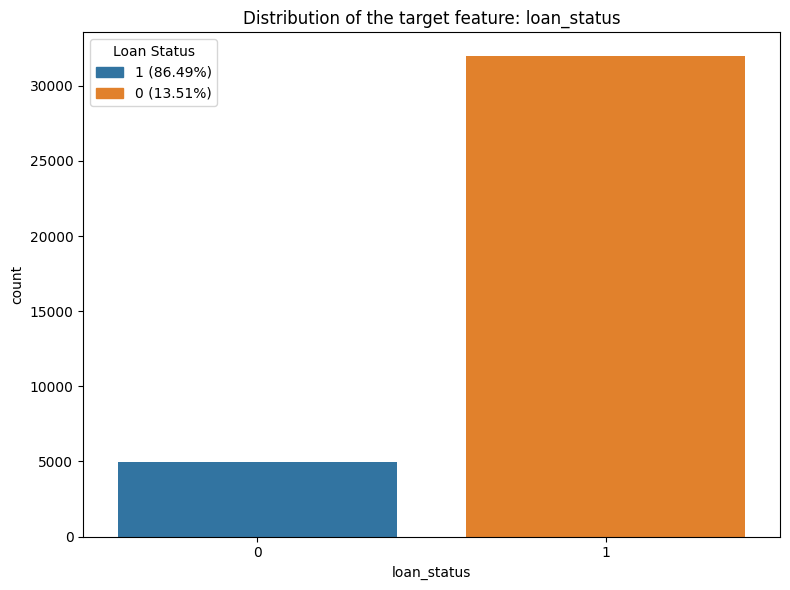

In [404]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=iso_df, x='loan_status', hue='loan_status', legend=False)

# Create handles (use the bars' colors) and labels
target_classes = iso_df['loan_status'].unique()
percentages = iso_df['loan_status'].value_counts(normalize=True).loc[target_classes] * 100
handles = [plt.Rectangle((0,0),1,1, color=bar.get_facecolor()) for bar in ax.patches]
labels = [f"{cls} ({percentages[cls]:.2f}%)" for cls in target_classes]

plt.legend(handles, labels, title='Loan Status')
plt.title('Distribution of the target feature: loan_status')
plt.tight_layout()
plt.show()

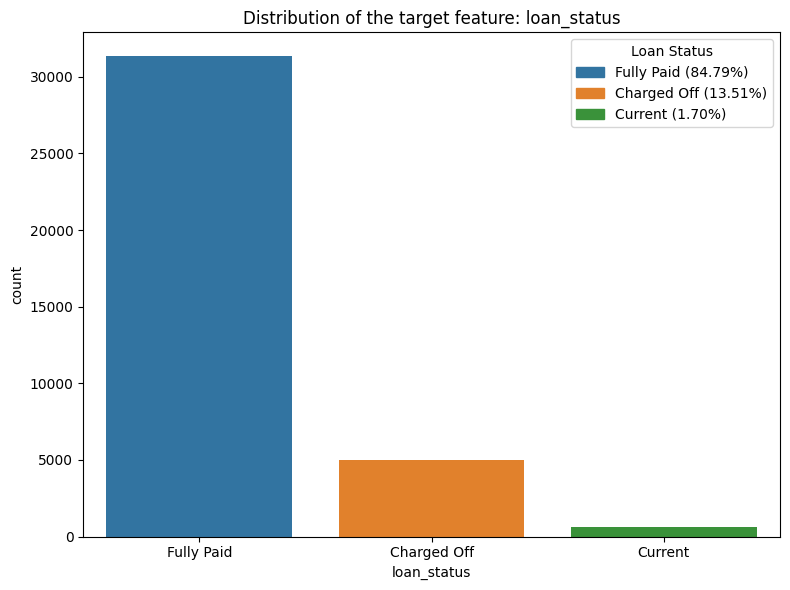

In [331]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=iso_df, x='loan_status', hue='loan_status', legend=False)

# Create handles (use the bars' colors) and labels
target_classes = iso_df['loan_status'].unique()
percentages = iso_df['loan_status'].value_counts(normalize=True).loc[target_classes] * 100
handles = [plt.Rectangle((0,0),1,1, color=bar.get_facecolor()) for bar in ax.patches]
labels = [f"{cls} ({percentages[cls]:.2f}%)" for cls in target_classes]

plt.legend(handles, labels, title='Loan Status')
plt.title('Distribution of the target feature: loan_status')
plt.tight_layout()
plt.show()

#### Bivariate/Multivariate Analysis

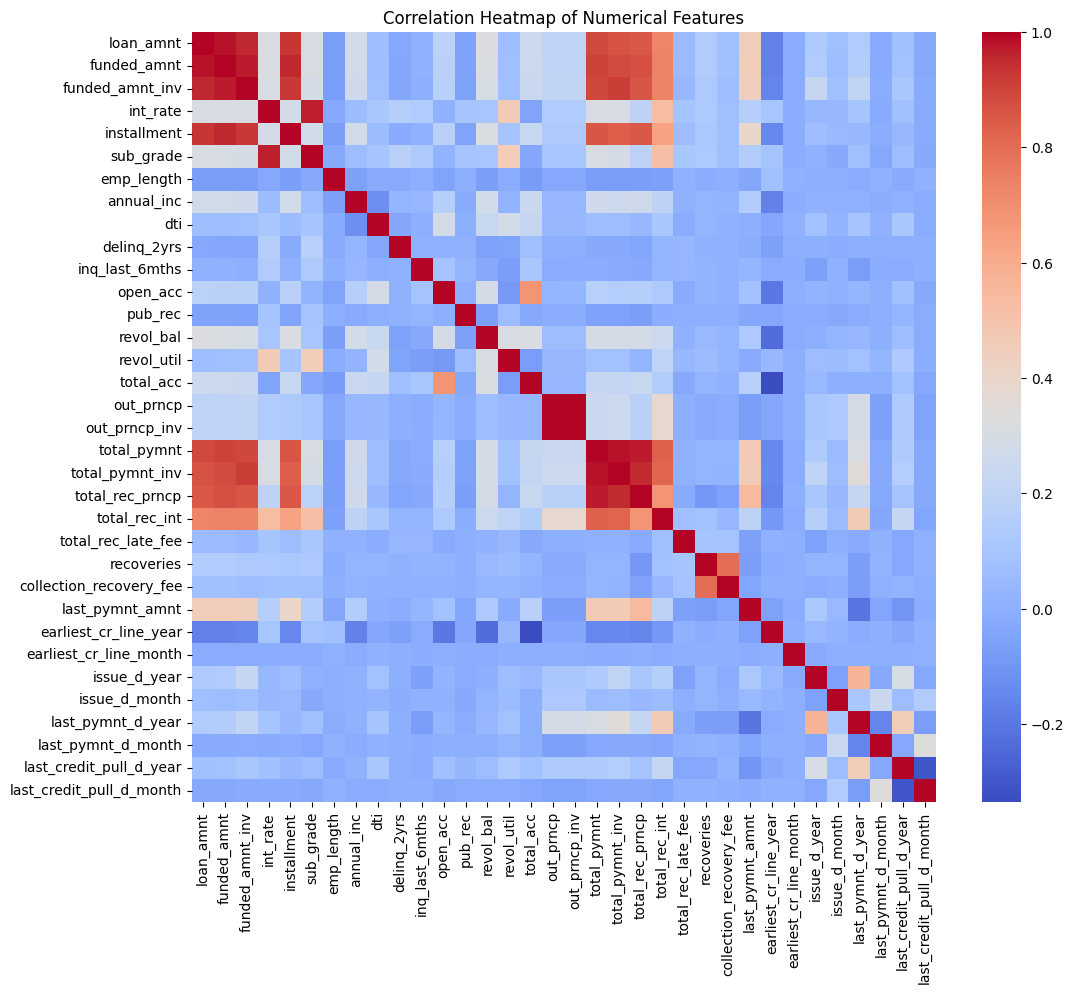

In [67]:
correlation_matrix = numeric_df[num_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

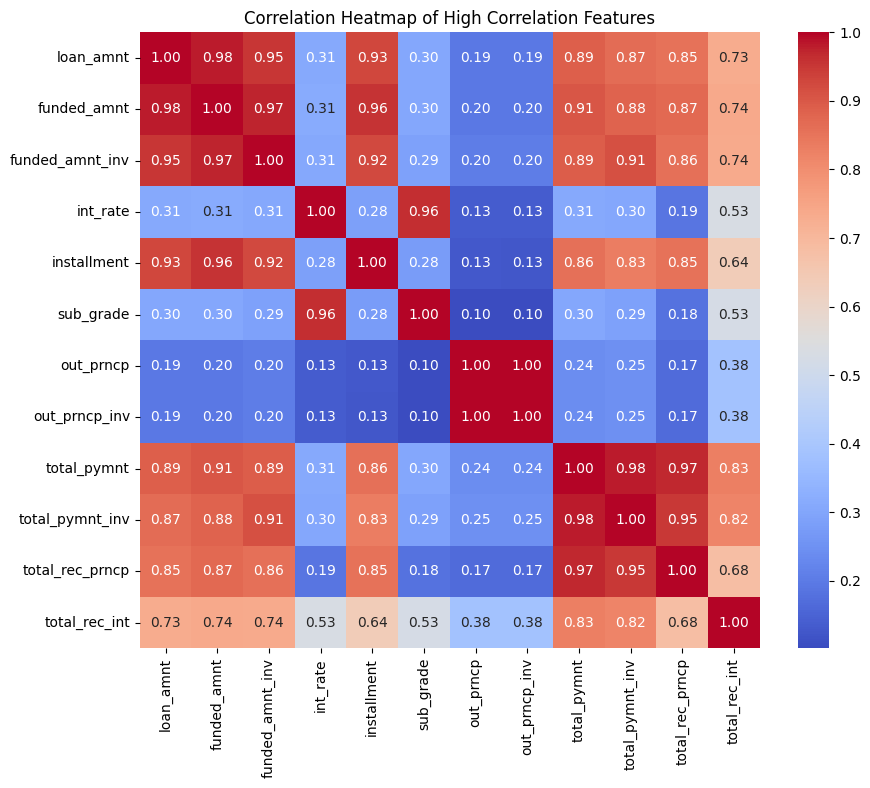

In [68]:
high_corr_features_1 = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'sub_grade',
                        'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int']
correlation_matrix = numeric_df[high_corr_features_1].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of High Correlation Features')
plt.show()

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap

period_columns = df.select_dtypes(include=['period[M]']).columns
X = df.drop(columns=['loan_status'] + list(period_columns))
y = df['loan_status']
feature_names = X.columns

# Train-test split
TRAIN_SIZE = 0.8
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=TRAIN_SIZE, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, train_size=TRAIN_SIZE, random_state=0)

# Normalization
scaler = StandardScaler()

scaler.fit(X_train)
for dataframe in [X_train, X_valid, X_test]:
    scaled_values = scaler.transform(dataframe)
    scaled_df = pd.DataFrame(
        scaled_values, columns=dataframe.columns, index=dataframe.index)
    dataframe = scaled_df

# Model configuration
X_train_gbm = X_train
X_valid_gbm = X_valid
X_test_gbm = X_test

# categorical_features = ['term', 'sub_grade', 'emp_length', 'purpose']

for col in cat_cols:
    X_train_gbm[col] = X_train_gbm[col].astype('category')

for col in cat_cols:
    X_valid_gbm[col] = X_valid_gbm[col].astype('category')

for col in cat_cols:
    X_test_gbm[col] = X_test_gbm[col].astype('category')

lgb_train = lgb.Dataset(
    X_train_gbm, y_train,
    categorical_feature=cat_cols,
    free_raw_data=False,
)

lgb_valid = lgb.Dataset(
    X_valid_gbm, y_valid,
    categorical_feature=cat_cols,
    free_raw_data=False,
    reference=lgb_train,
)

params = {
    "objective": "binary",
    "num_iterations": 3000,
    "metric": ["auc", "binary_logloss"],
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 4,
    "max_depth": 4,
    "num_threads": 4,
    "tree_learner": "serial",
    # "lambda_l2": 0.05,
    # "path_smooth": 128,
    "early_stopping_round": 200,
    "feature_pre_filter": False,
    "first_metric_only": True,
}

# Train the model
gbm_model = lgb.train(
    params,
    train_set=lgb_train,
    valid_sets=[lgb_train, lgb_valid],
    callbacks=[
        lgb.early_stopping(100, first_metric_only=True),
        lgb.log_evaluation(50, show_stdv=True)
    ]
)

explainer = shap.TreeExplainer(gbm_model)
shap_values = explainer.shap_values(X_test_gbm)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 21450, number of negative: 3446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5114
[LightGBM] [Info] Number of data points in the train set: 24896, number of used features: 50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.861584 -> initscore=1.828511
[LightGBM] [Info] Start training from score 1.828511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

c:\Users\PC\anaconda3\envs\loan\lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


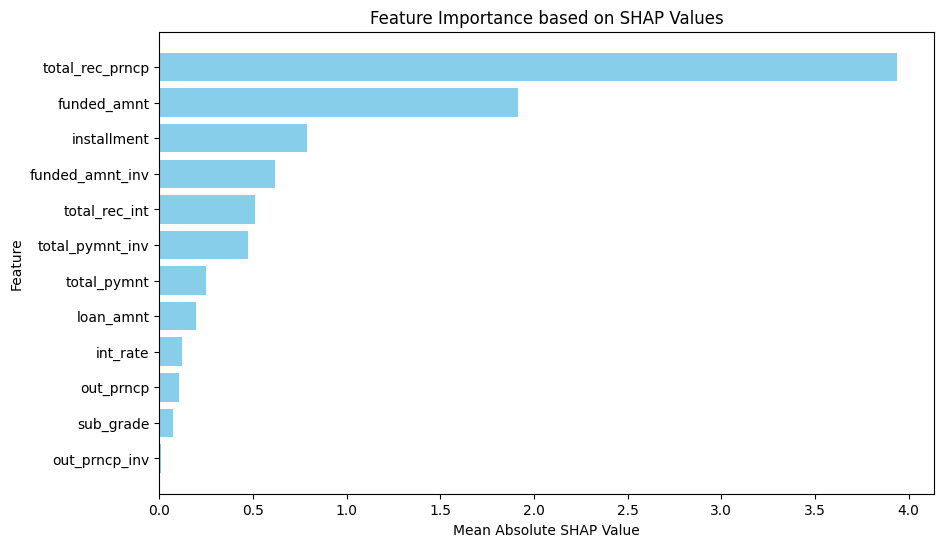

In [70]:
shap_summary = np.abs(shap_values).mean(axis=0) 
shap_summary_df = pd.DataFrame({'Feature': feature_names, 'SHAP values': shap_summary})
shap_summary_df = shap_summary_df.sort_values('SHAP values', ascending=False)
shap_summary_df = shap_summary_df[shap_summary_df['Feature'].isin(high_corr_features_1)]

# Visualization
plt.figure(figsize=(10, 6))
plt.barh(shap_summary_df['Feature'], shap_summary_df['SHAP values'], color='skyblue')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Feature')
plt.title('Feature Importance based on SHAP Values')
plt.gca().invert_yaxis() 
plt.show()

**Initial Observations:**

*  Ta giữ lại các feature theo thứ tự giảm dần của Feature Importance dựa trên SHAP values, các feature đó là: `total_rec_prncp`

In [85]:
remove_features = high_corr_features_1.copy()
remove_features.remove('total_rec_prncp')

df.drop(columns=remove_features, inplace=True)
df.info()

term  emp_length  annual_inc  issue_d  loan_status  purpose    dti  \
0     0           1     24000.0  2011-12            1        0  27.65   
1     1          10     30000.0  2011-12            0        0   1.00   
2     0           1     12252.0  2011-12            1        0   8.72   
3     0           1     49200.0  2011-12            1        0  20.00   
4     1           0     80000.0  2011-12            1        0  17.94   

   delinq_2yrs earliest_cr_line  inq_last_6mths  ...  \
0            0          1985-01               1  ...   
1            0          1999-04               5  ...   
2            0          2001-11               2  ...   
3            0          1996-02               1  ...   
4            0          1996-01               0  ...   

   verification_status_Verified  home_ownership_MORTGAGE  home_ownership_NONE  \
0                             1                        0                    0   
1                             0                        0                    0   
2                             0                        0                    0   
3                             0                        0                    0   
4                             0                        0                    0   

   home_ownership_OTHER  home_ownership_OWN  home_ownership_RENT  \
0                     0                   0                    1   
1                     0                   0                    1   
2                     0                   0                    1   
3                     0                   0                    1   
4                     0                   0                    1   

   region_Midwest  region_Northeast  region_South region_West  
0               0                 0             0           1  
1               0                 0             1           0  
2               1                 0             0           0  
3               0                 0             0           1  
4               0                 0             0           1  

[5 rows x 44 columns]

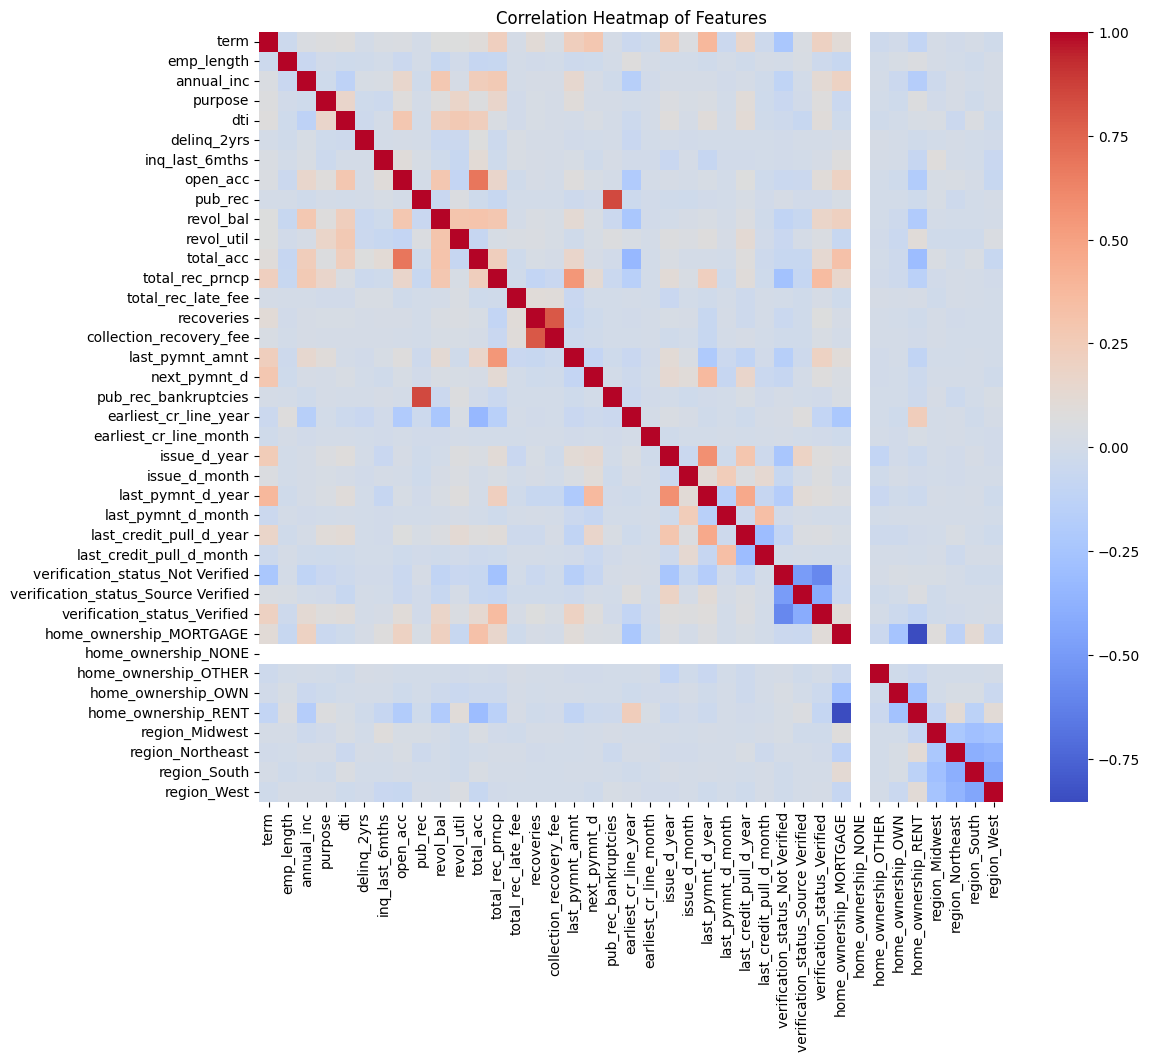

In [95]:
period_columns = df.select_dtypes(include=['period[M]']).columns
X = df.drop(columns=['loan_status'] + list(period_columns))
y = df['loan_status']
corr_matrix = X.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Heatmap of Features')
plt.show()

#### Handling Outliers

In [64]:
df.describe().T.map('{:.2f}'.format)

count      mean       std      min  \
loan_amnt                            38902.00  11255.19   7471.53   500.00   
funded_amnt                          38902.00  10980.03   7198.86   500.00   
funded_amnt_inv                      38902.00  10555.81   7103.75     0.00   
term                                 38902.00      0.27      0.45     0.00   
int_rate                             38902.00      0.12      0.04     0.05   
installment                          38902.00    324.93    208.81    16.08   
sub_grade                            38902.00      9.92      6.81     0.00   
emp_length                           38902.00      4.19      3.37     0.00   
annual_inc                           38902.00  69027.27  63189.50  4000.00   
purpose                              38902.00      0.47      0.50     0.00   
dti                                  38902.00     13.37      6.67     0.00   
delinq_2yrs                          38902.00      0.15      0.49     0.00   
inq_last_6mths                       38902.00      0.87      1.07     0.00   
open_acc                             38902.00      9.30      4.38     2.00   
pub_rec                              38902.00      0.06      0.24     0.00   
revol_bal                            38902.00  13404.47  15848.89     0.00   
revol_util                           38902.00      0.49      0.28     0.00   
total_acc                            38902.00     22.17     11.39     2.00   
out_prncp                            38902.00     52.30    379.01     0.00   
out_prncp_inv                        38902.00     52.06    377.65     0.00   
total_pymnt                          38902.00  12219.38   9068.26    33.73   
total_pymnt_inv                      38902.00  11758.33   8929.63     0.00   
total_rec_prncp                      38902.00   9840.46   7078.30     0.00   
total_rec_int                        38902.00   2283.49   2626.07     6.22   
total_rec_late_fee                   38902.00      1.33      7.14     0.00   
recoveries                           38902.00     94.10    684.65     0.00   
collection_recovery_fee              38902.00     12.10    146.98     0.00   
last_pymnt_amnt                      38902.00   2706.32   4468.58     0.01   
next_pymnt_d                         38902.00      0.03      0.17     0.00   
pub_rec_bankruptcies                 38902.00      0.04      0.20     0.00   
earliest_cr_line_year                38902.00   1996.80      7.41  1969.00   
earliest_cr_line_month               38902.00      6.89      3.54     1.00   
issue_d_year                         38902.00   2010.38      0.81  2007.00   
issue_d_month                        38902.00      7.22      3.37     1.00   
last_pymnt_d_year                    38902.00   2012.87      1.50  2008.00   
last_pymnt_d_month                   38902.00      6.46      3.42     1.00   
last_credit_pull_d_year              38902.00   2014.33      1.74  2007.00   
last_credit_pull_d_month             38902.00      5.82      3.02     1.00   
verification_status_Not Verified     38902.00      0.42      0.49     0.00   
verification_status_Source Verified  38902.00      0.26      0.44     0.00   
verification_status_Verified         38902.00      0.33      0.47     0.00   
home_ownership_MORTGAGE              38902.00      0.45      0.50     0.00   
home_ownership_NONE                  38902.00      0.00      0.00     0.00   
home_ownership_OTHER                 38902.00      0.00      0.05     0.00   
home_ownership_OWN                   38902.00      0.08      0.27     0.00   
home_ownership_RENT                  38902.00      0.47      0.50     0.00   
region_Midwest                       38902.00      0.14      0.35     0.00   
region_Northeast                     38902.00      0.24      0.43     0.00   
region_South                         38902.00      0.33      0.47     0.00   
region_West                          38902.00      0.29      0.45     0.00   

                                          25%       50%      

In [65]:
df['installment'].describe().map('{:.2f}'.format)

count    38902.00
mean       324.93
std        208.81
min         16.08
25%        167.34
50%        280.62
75%        430.95
max       1305.19
Name: installment, dtype: object

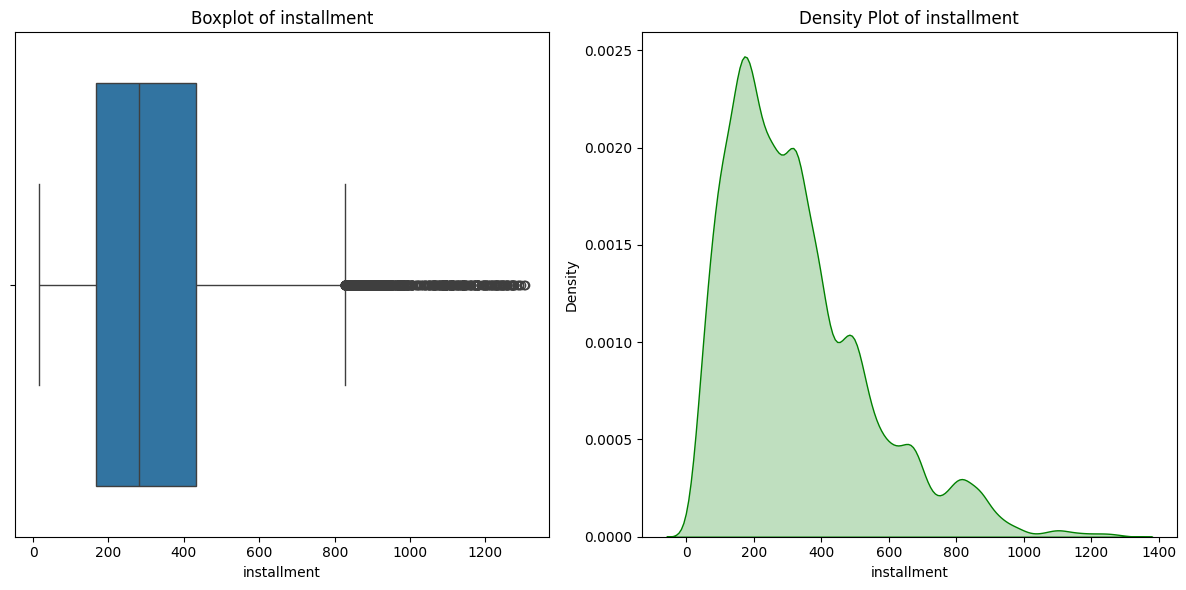

In [66]:
# Boxplot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Boxplot of installment')
sns.boxplot(x=df['installment'])
plt.xlabel('installment')


# Density plot
plt.subplot(1, 2, 2)
plt.title('Density Plot of installment')
sns.kdeplot(df['installment'], color = 'green', fill=True)
plt.xlabel('installment')


plt.tight_layout()
plt.show()

In [67]:
df['annual_inc'].describe().map('{:.2f}'.format)

count      38902.00
mean       69027.27
std        63189.50
min         4000.00
25%        40800.00
50%        59308.50
75%        82500.00
max      6000000.00
Name: annual_inc, dtype: object

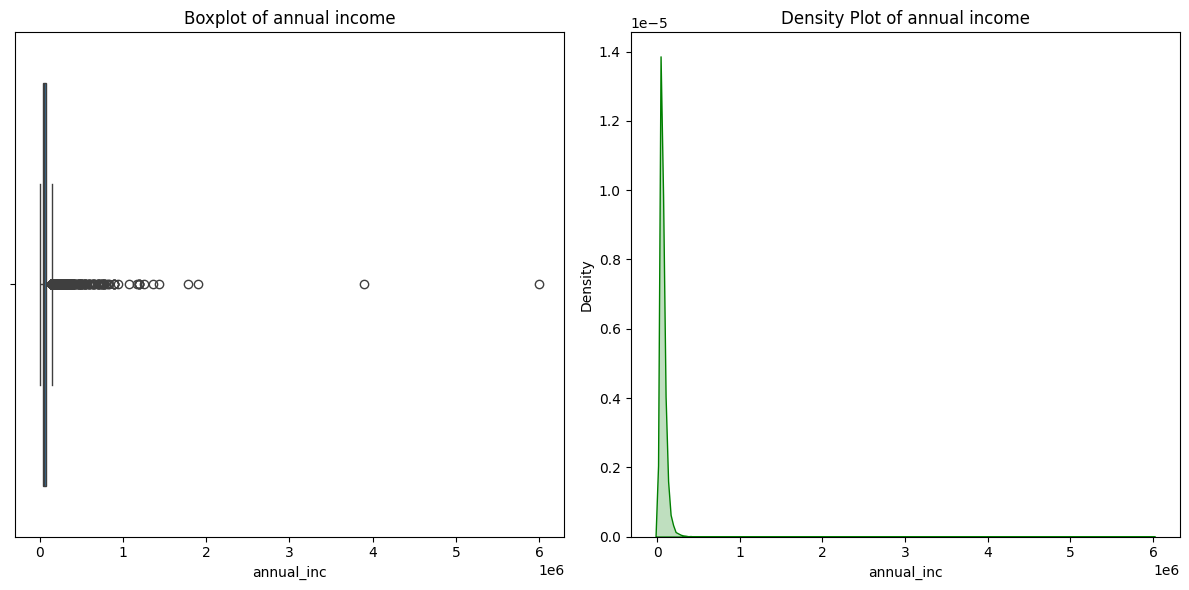

In [68]:
# Boxplot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Boxplot of annual income')
sns.boxplot(x=df['annual_inc'])
plt.xlabel('annual_inc')


# Density plot
plt.subplot(1, 2, 2)
plt.title('Density Plot of annual income')
sns.kdeplot(df['annual_inc'], color = 'green', fill=True)
plt.xlabel('annual_inc')


plt.tight_layout()
plt.show()

**Initial Observations:**

*  The `installment` feature contains a large number of outliers, as evidenced by the mean (324.56) being significantly higher than the median (280.22), indicating a right-skew caused by large values.

*  The `annual_inc` feature has some extreme outliers with very high values, which heavily skew the distribution to the right.

⇒ We will remove some of these outliers to make the distributions of these features closer to a normal distribution.

In [69]:
P = np.percentile(df['installment'], [5, 95])
df = df[(df['installment'] >= P[0]) & (df['installment'] <= P[1])]
df['installment'].describe()

count    35013.000000
mean       309.062688
std        161.415270
min         72.040000
25%        177.250000
50%        280.620000
75%        406.780000
max        762.080000
Name: installment, dtype: float64

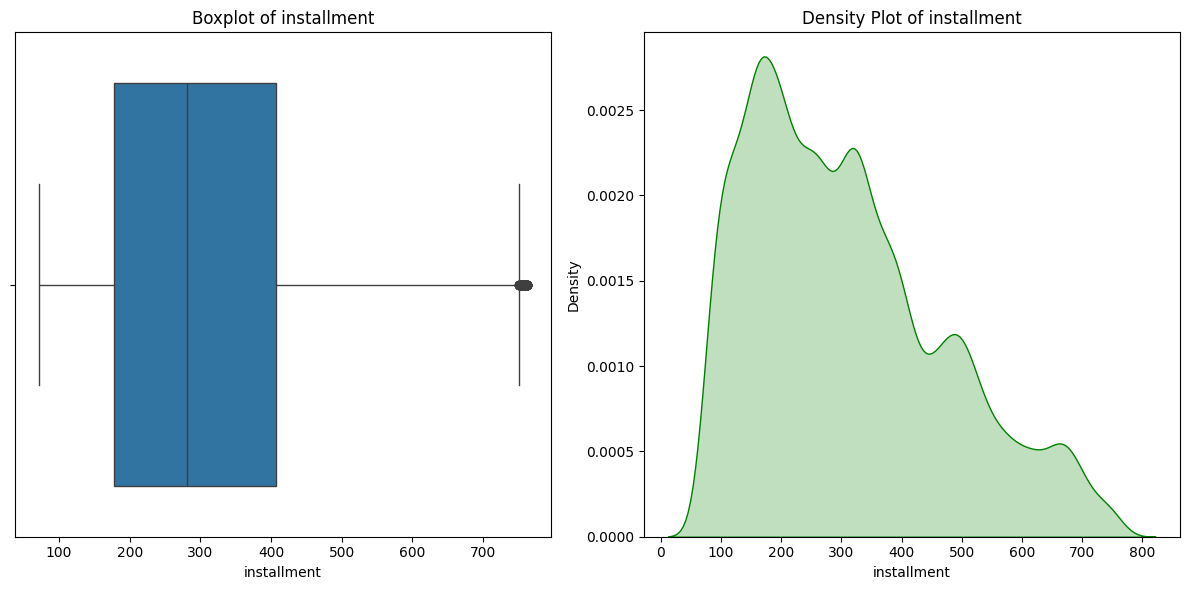

In [70]:
# Boxplot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Boxplot of installment')
sns.boxplot(x=df['installment'])
plt.xlabel('installment')


# Density plot
plt.subplot(1, 2, 2)
plt.title('Density Plot of installment')
sns.kdeplot(df['installment'], color = 'green', fill=True)
plt.xlabel('installment')


plt.tight_layout()
plt.show()

In [71]:
P = np.percentile(df['annual_inc'], [5, 95])
df = df[(df['annual_inc'] >= P[0]) & (df['annual_inc'] <= P[1])]
df['annual_inc'].describe()

count     31530.000000
mean      62457.079283
std       25117.793758
min       24996.000000
25%       42500.000000
50%       58000.000000
75%       78000.000000
max      135000.000000
Name: annual_inc, dtype: float64

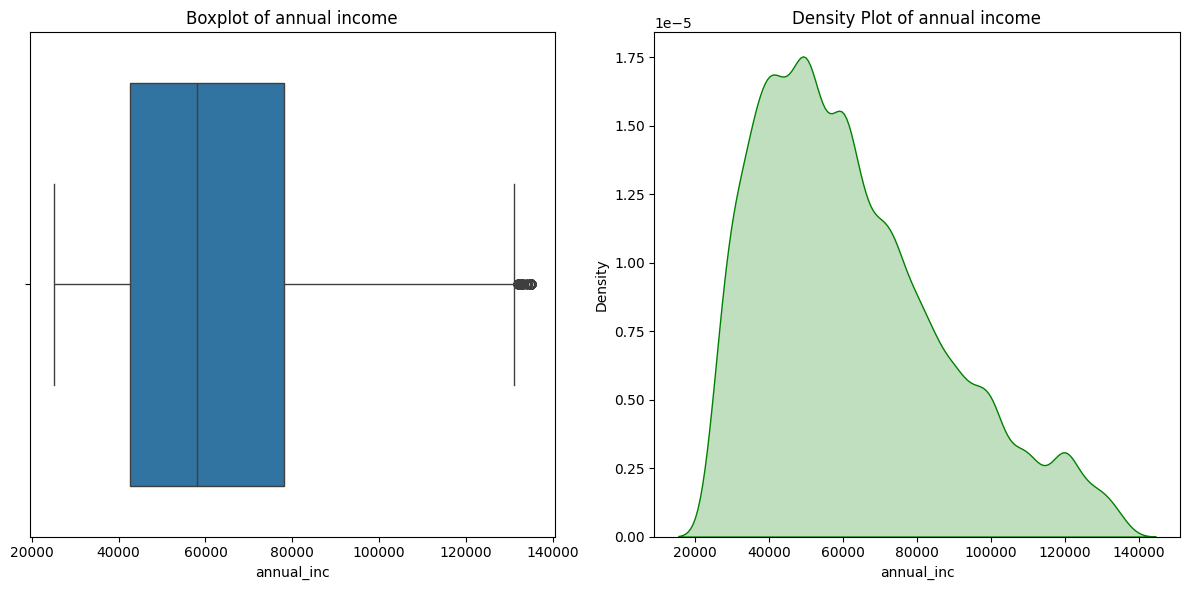

In [72]:
# Boxplot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Boxplot of annual income')
sns.boxplot(x=df['annual_inc'])
plt.xlabel('annual_inc')


# Density plot
plt.subplot(1, 2, 2)
plt.title('Density Plot of annual income')
sns.kdeplot(df['annual_inc'], color = 'green', fill=True)
plt.xlabel('annual_inc')


plt.tight_layout()
plt.show()

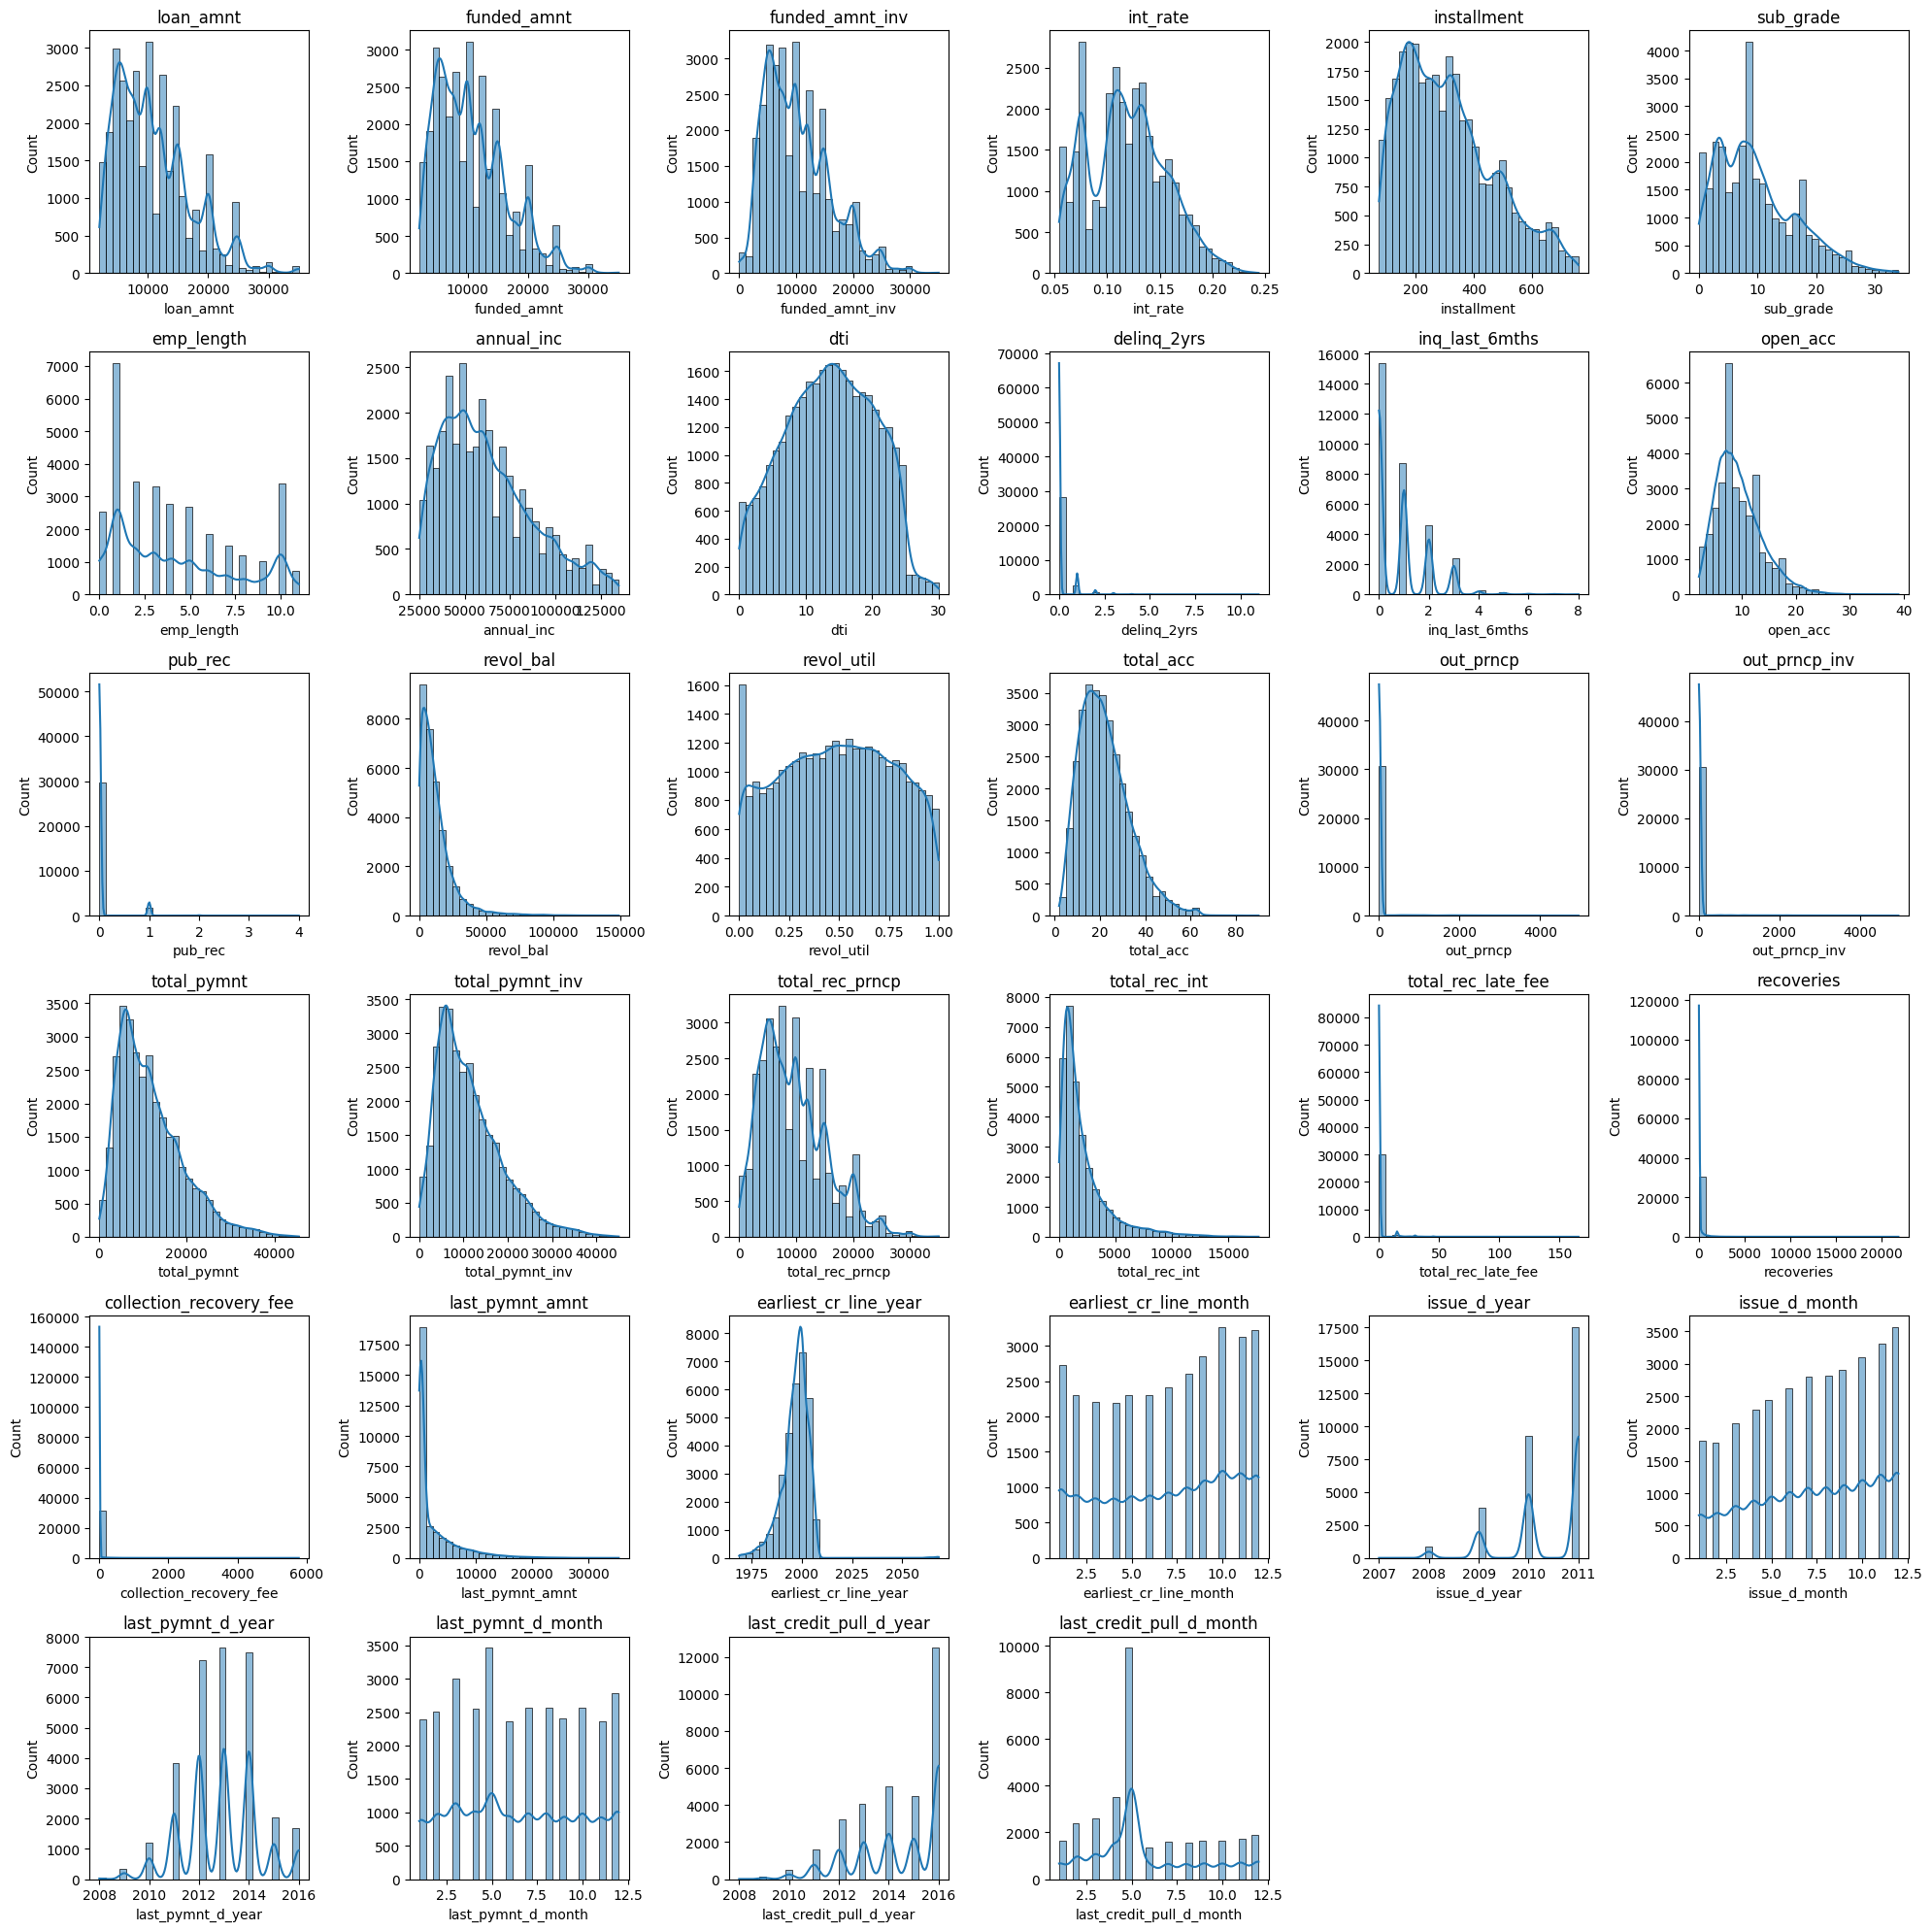

In [83]:
plot_distributions(df, num_cols, kind='hist', cols=6, figsize=(20, 20))

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess data (replace with your data)
X = df.drop(columns=['target'])  # Features
y = df['target']                 # Target

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # Adjust contamination
outliers_iso = iso_forest.fit_predict(X_scaled)

# Flag outliers (-1 for outliers, 1 for inliers)
df['outlier_iso'] = np.where(outliers_iso == -1, 1, 0)

# Visualize outliers in 2D using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['outlier_iso'], palette='viridis')
plt.title('Isolation Forest Outliers (PCA)')
plt.show()

In [90]:
df[num_cols]

loan_amnt  funded_amnt  funded_amnt_inv  int_rate  installment  \
3          10000        10000          10000.0    0.1349       339.31   
5           5000         5000           5000.0    0.0790       156.46   
6           7000         7000           7000.0    0.1596       170.08   
7           3000         3000           3000.0    0.1864       109.43   
8           5600         5600           5600.0    0.2128       152.39   
...          ...          ...              ...       ...          ...   
39562       4800         4800           1100.0    0.1028       155.52   
39573       7000         7000           1000.0    0.1059       227.82   
39623       9000         9000            700.0    0.1249       301.04   
39666      15450        15450            600.0    0.1122       507.46   
39680       3000         3000            525.0    0.1186        99.44   

       sub_grade  emp_length  annual_inc    dti  delinq_2yrs  ...  \
3             10           1     49200.0  20.00            0  ...   
5              3           3     36000.0  11.20            0  ...   
6             14           8     47004.0  23.51            0  ...   
7             20           9     48000.0   5.35            0  ...   
8             26           4     40000.0   5.55            0  ...   
...          ...         ...         ...    ...          ...  ...   
39562         10           0     35000.0   7.51            0  ...   
39573         11           3     63500.0   8.50            0  ...   
39623         17           8     39000.0   5.08            0  ...   
39666         13           2     40000.0  13.50            0  ...   
39680         15           2     36153.0   7.47            0  ...   

       collection_recovery_fee  last_pymnt_amnt  earliest_cr_line_year  \
3                         0.00           357.48                   1996   
5                         0.00           161.03                   2004   
6                         0.00          1313.76                   2005   
7                         0.00           111.34                   2007   
8                         2.09           152.39                   2004   
...                        ...              ...                    ...   
39562                     0.00          3891.08                   2000   
39573                     0.00          1571.29                   1989   
39623                   668.36           301.05                   1997   
39666                     3.09          1016.15                   1992   
39680                     0.00           101.51                   2000   

       earliest_cr_line_month  issue_d_year  issue_d_month  last_pymnt_d_year  \
3                           2          2011             12               2015   
5                          11          2011             12               2015   
6                           7          2011             12               2016   
7                           1          2011             12               2015   
8                           4          2011             12               2012   
...                       ...           ...            ...                ...   
39562                       3          2007             11               2008   
39573                       2          2007             11               2010   
39623                       8          2007             10               2008   
39666                      11          2007              8               2009   
39680                       7          2007              8               2010   

       last_pymnt_d_month  last_credit_pull_d_year  last_credit_pull_d_month  
3                       1                     2016                         4  
5                       1                     2016                         1  
6                       5                     2016                         5  
7                       1                     2014                        12  
8                       4                   

**Loại bỏ các biến có kiểu dữ liệu là Period vì các thư viện sử dụng để phân tích không hỗ trợ xử lý kiểu dữ liệu này.**

In [76]:
period_columns = df.select_dtypes(include=['period[M]']).columns

In [77]:
X = df.drop(columns=['loan_status'] + list(period_columns))
y = df['loan_status']

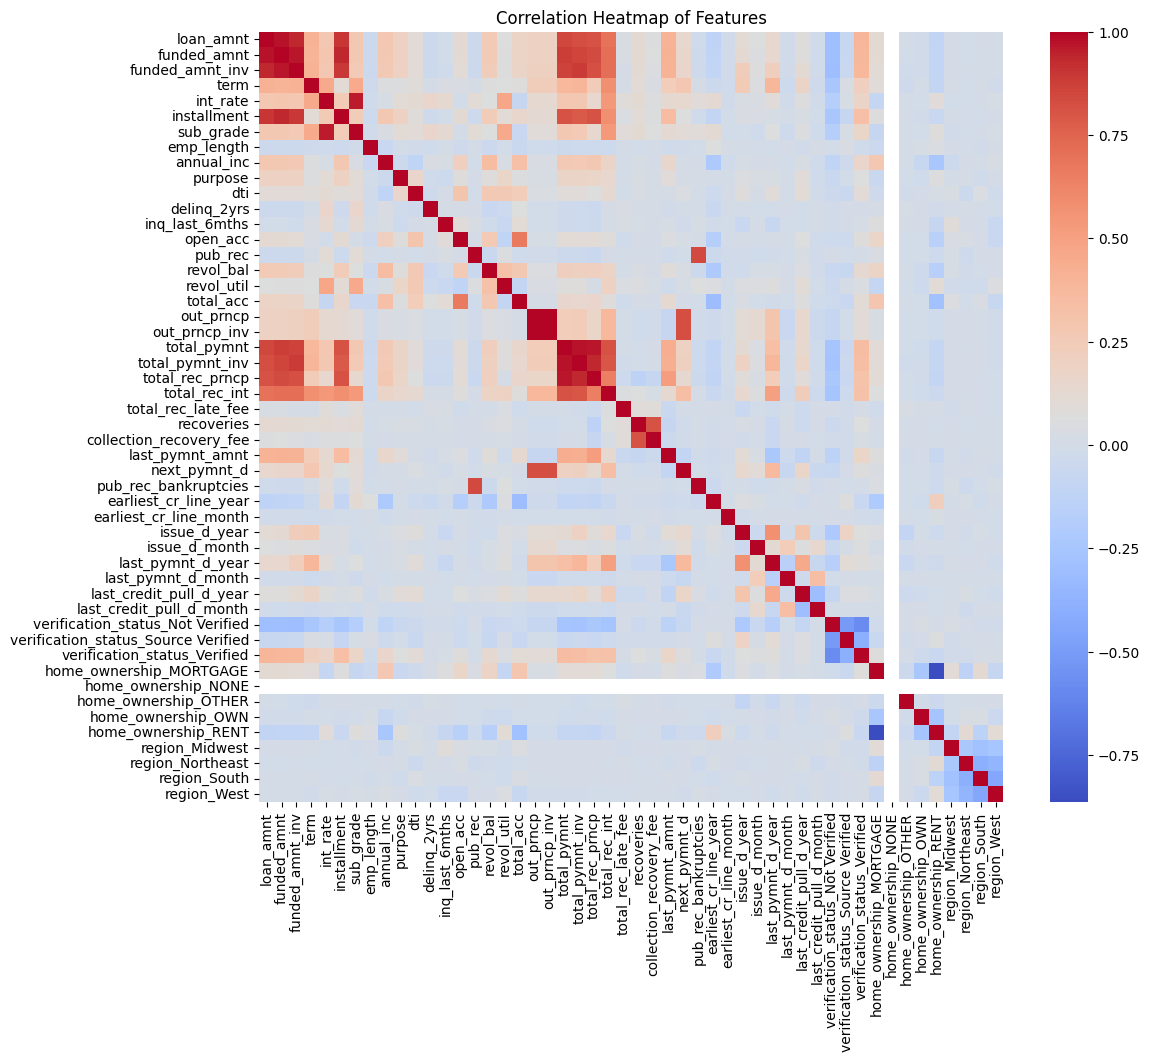

In [92]:
corr_matrix = X.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Heatmap of Features')
plt.show()

**Trực quan hóa tương quan giữa các feature và biến mục tiêu `loan_status`.**

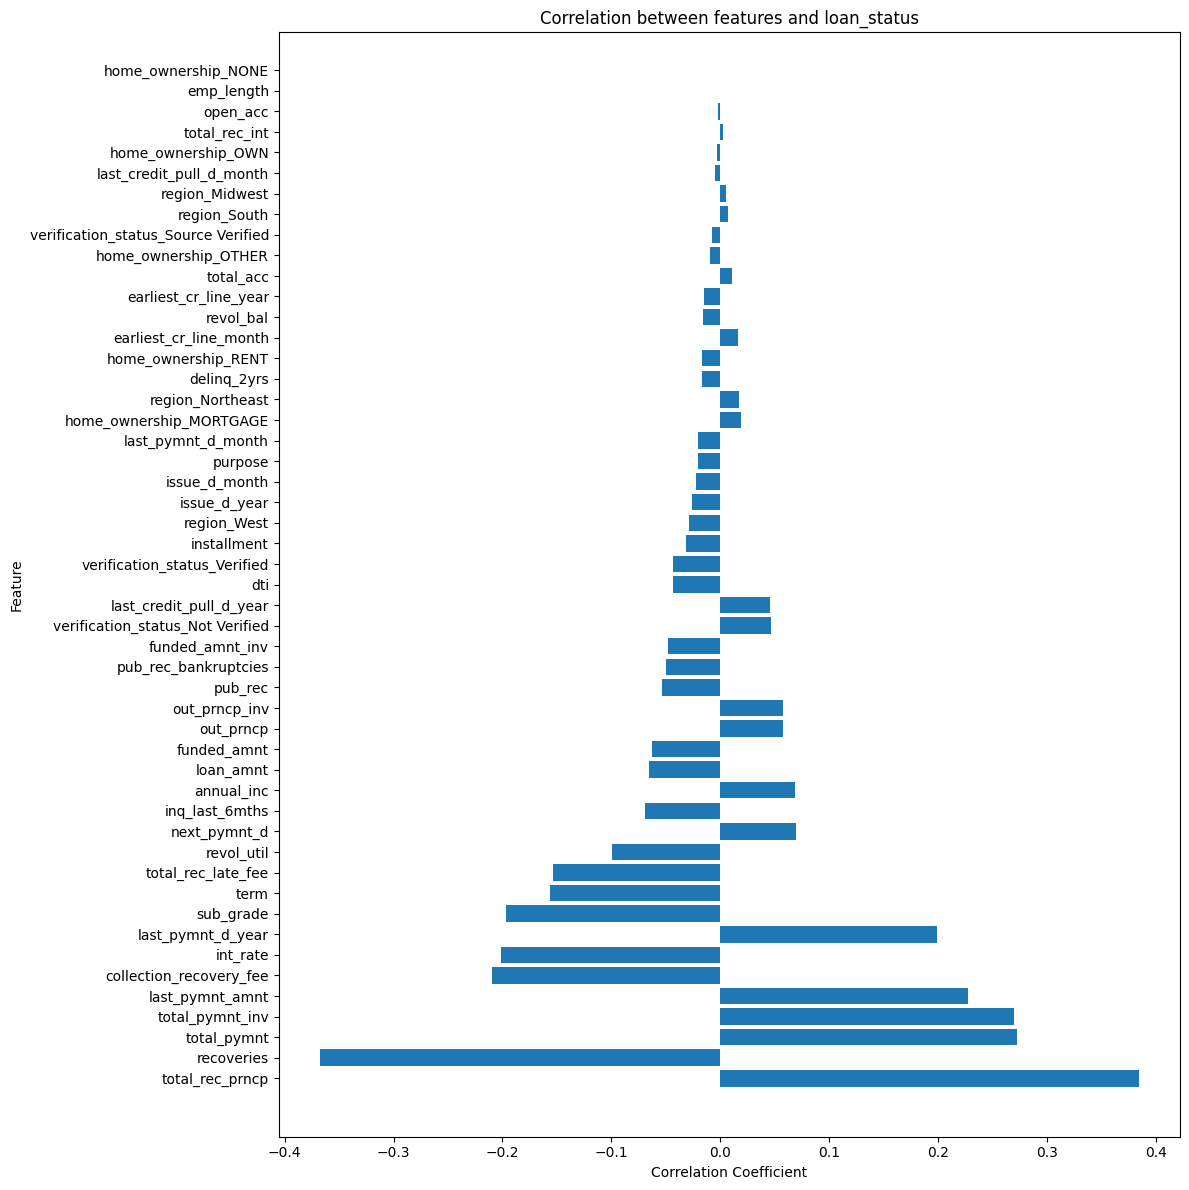

In [78]:
correlation_matrix = df.drop(columns=list(period_columns)).corr()
correlation_coef = correlation_matrix['loan_status'].drop('loan_status')
features = X.columns

loan_status_correlations = pd.DataFrame({
    'Feature': features,
    'Correlation': correlation_coef
})

# Select correlations with 'loan_status'
loan_status_correlations['Abs Correlation'] = np.abs(
    loan_status_correlations['Correlation'])
loan_status_correlations_sorted = loan_status_correlations.sort_values(
    by='Abs Correlation', ascending=False)

# Plot the correlations
plt.figure(figsize=(12, 12))
plt.barh(loan_status_correlations_sorted['Feature'],
         loan_status_correlations_sorted['Correlation'])
plt.title('Correlation between features and loan_status')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

**Nhận xét nhanh:**

*  Không có biến nào có tương quan mạnh (>0,5) với biến mục tiêu `loan_status`. 
*  Tuy có tới 53 biến đặc trưng (feature) nhưng chỉ có khoảng 10-11 biến có tương quan đáng chú ý với biến mục tiêu `loan_status` gồm: `recoveries`, `total_rec_prncp`, `total_pymnt`, `total_pymnt_inv`, `last_pymnt_amnt`, `last_pymnt_d_year`, `collection_recovery_fee`, `int_rate`, `sub_grade`, `total_rec_late_fee`, `term`.

⇒ Ta dự doán có thể các mô hình chỉ cần dựa vào khoảng 10 biến này để đạt được kết quả không quá khác biệt so với sử dụng cả 53 biến. Từ đó, ta có thể sẽ thiết kế được một mô hình mới đơn giản hơn với hiệu quả tương đương.

**Dùng PCA để trực quan hóa phân phối của bộ dữ liệu.**

In [79]:
numerical_features = X.select_dtypes(include=np.number)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_features)

In [80]:
pca = PCA(n_components=3)
principal_components = pca.fit_transform(scaled_data)

In [81]:
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
pca_df['loan_status'] = df['loan_status'].values

In [82]:
fig = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3', color='loan_status',
                    title='PCA 3D Scatter Plot of Loan Status Classes')

fig.show()

**Nhận xét nhanh:**

*  Từ đồ thị phân tán, ta dễ thấy 2 lớp `Accept` và `Reject` của lớp `loan_status` được chia thành 2 phần tách biệt nhau rất rõ ràng.

⇒ Đây là một tín hiệu tốt, ta kỳ vọng các mô hình có thể phân loại tốt 2 lớp với bộ dữ liệu này. Thậm chí, các mô hình có thể không cần quá phức tạp để có thể phân loại tốt 2 lớp trên.

### Train - Test Split

In [136]:
X = df.drop(columns=['loan_status', 'recoveries', 'collection_recovery_fee'] + list(period_columns))
y = df['loan_status']

In [137]:
TRAIN_SIZE = 0.8

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=TRAIN_SIZE, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, train_size=TRAIN_SIZE, random_state=0)

In [138]:
X_train.shape, X_valid.shape, X_test.shape

((24896, 37), (6225, 37), (7781, 37))

### Chuẩn hóa dữ liệu

In [ ]:
df.describe().T.map('{:.2f}'.format)

count      mean       std       min       25%  \
loan_amnt                 31587.00  10868.17   6076.62   2000.00   6000.00   
funded_amnt               31587.00  10579.83   5725.37   2000.00   6000.00   
funded_amnt_inv           31587.00  10179.96   5705.53      0.00   5750.00   
term                      31587.00      0.28      0.45      0.00      0.00   
int_rate                  31587.00      0.12      0.04      0.05      0.09   
installment               31587.00    310.85    158.61     71.28    183.28   
sub_grade                 31587.00      9.72      6.68      0.00      4.00   
emp_length                31587.00      4.14      3.31      0.00      1.00   
annual_inc                31587.00  62406.80  25134.19  24500.00  42294.00   
loan_status               31587.00      0.86      0.34      0.00      1.00   
purpose                   31587.00      3.74      3.37      0.00      2.00   
dti                       31587.00     13.63      6.62      0.00      8.59   
delinq_2yrs               31587.00      0.14      0.49      0.00      0.00   
inq_last_6mths            31587.00      0.86      1.06      0.00      0.00   
open_acc                  31587.00      9.36      4.30      2.00      6.00   
pub_rec                   31587.00      0.06      0.24      0.00      0.00   
revol_bal                 31587.00  12516.30  13341.60      0.00   4066.00   
revol_util                31587.00      0.49      0.28      0.00      0.26   
total_acc                 31587.00     22.18     11.04      2.00     14.00   
out_prncp                 31587.00     48.76    337.20      0.00      0.00   
out_prncp_inv             31587.00     48.55    336.01      0.00      0.00   
total_pymnt               31587.00  11737.04   7389.43     91.89   6066.59   
total_pymnt_inv           31587.00  11300.56   7330.47      0.00   5784.15   
total_rec_prncp           31587.00   9495.50   5777.10      0.00   5000.00   
total_rec_int             31587.00   2156.96   2224.59     11.64    734.06   
total_rec_late_fee        31587.00      1.15      6.23      0.00      0.00   
recoveries                31587.00     83.43    568.88      0.00      0.00   
collection_recovery_fee   31587.00     10.16    121.72      0.00      0.00   
last_pymnt_amnt           31587.00   2594.78   3994.16      0.01    240.40   
policy_code               31587.00      1.00      0.00      1.00      1.00   
pub_rec_bankruptcies      31587.00      0.05      0.21      0.00      0.00   
earliest_cr_line_year     31587.00   1996.88      7.17   1969.00   1994.00   
earliest_cr_line_month    31587.00      6.89      3.54      1.00      4.00   
issue_d_year              31587.00   2010.38      0.81   2007.00   2010.00   
issue_d_month             31587.00      7.21      3.37      1.00      4.00   
last_pymnt_d_year         31587.00   2012.89      1.50   2008.00   2012.00   
last_pymnt_d_month        31587.00      6.45      3.42      1.00      3.00   
last_credit_pull_d_year   31587.00   2014.36      1.73   2008.00   2013.00   
last_credit_pull_d_month  31587.00      5.80      3.01      1.00      4.00   

                               50%       75%        max  
loan_amnt                 10000.00  15000.00   35000.00  
funded_amnt               10000.00  14400.00   35000.00  
funded_amnt_inv            9375.00  13950.00   35000.00  
term                          0.00      1.00       1.00  
int_rate                      0.12      0.14       0.24  
installment                 285.29    406.80     762.08  
sub_grade                     9.00     14.00      34.00  
emp_length                    3.00      6.00      11.00  
annual_inc                58000.00  78000.00  135000.00  
loan_status                   1.00      1.00       1.00  
purpose                       2.00      6.00      13.00  
dti                          13.76     18.85      29.99  
delinq_2yrs                   0.00      0.00      11.00  
inq_last_6mths                1.00      1.00       8.00  
open_acc                      9.00    

Vì các biến đặc trưng nằm trong nhiều khoảng giá trị khác nhau nên ta sẽ chuẩn hóa để đưa chúng về gần nhau hơn.

In [139]:
scaler = StandardScaler()

scaler.fit(X_train)
for dataframe in [X_train, X_valid, X_test]:
    scaled_values = scaler.transform(dataframe)
    scaled_df = pd.DataFrame(
        scaled_values, columns=dataframe.columns, index=dataframe.index)
    dataframe = scaled_df

## 4. Model Development

### Logistic Regression

In [121]:
start_time = time.time()

lr_model = LogisticRegression(solver='saga', max_iter=10000)
lr_model.fit(X_train, y_train)

end_time = time.time()
lr_train_time = end_time - start_time

In [122]:
y_pred_lr = lr_model.predict(X_test)

In [123]:
print("AUC-ROC (Logistic Regression):", roc_auc_score(y_test, y_pred_lr))

AUC-ROC (Logistic Regression): 0.569239858343878


In [124]:
print("Logistic Regression - Classification Report:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.15      0.25      1120
           1       0.87      0.99      0.93      6661

    accuracy                           0.87      7781
   macro avg       0.82      0.57      0.59      7781
weighted avg       0.86      0.87      0.83      7781



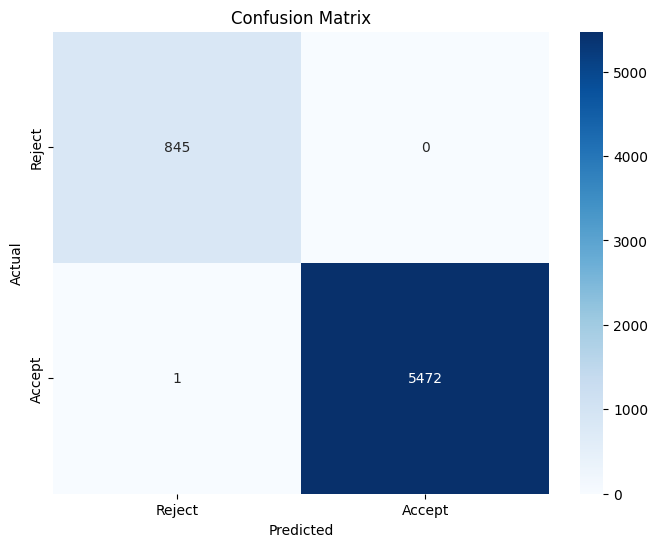

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Reject', 'Accept'],
            yticklabels=['Reject', 'Accept'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Decision Tree

In [ ]:
start_time = time.time()

dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

end_time = time.time()
dt_train_time = end_time - start_time

In [ ]:
y_pred_dt = dt_model.predict(X_test)

In [ ]:
print("AUC-ROC (Decision Tree):", roc_auc_score(y_test, y_pred_dt))

AUC-ROC (Decision Tree): 0.9804691562776708


In [ ]:
print("Decision Tree - Classification Report:")
print(classification_report(y_test, y_pred_dt))

Decision Tree - Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       845
           1       0.99      1.00      1.00      5473

    accuracy                           0.99      6318
   macro avg       0.99      0.98      0.98      6318
weighted avg       0.99      0.99      0.99      6318



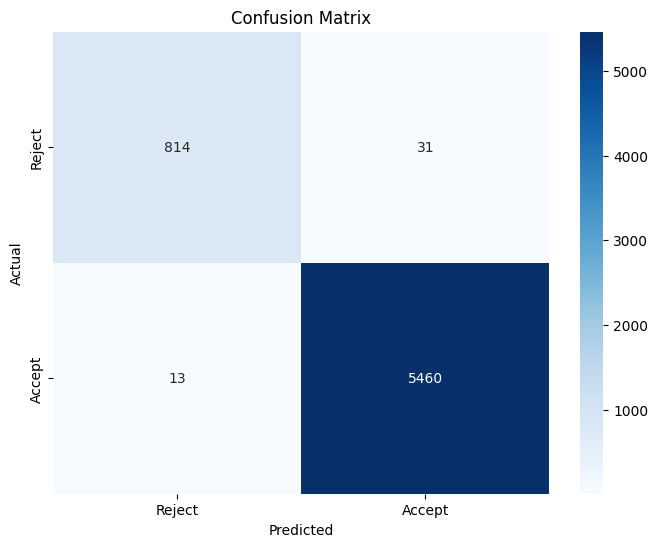

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Reject', 'Accept'],
            yticklabels=['Reject', 'Accept'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Gradient Boosting

In [140]:
X_train_gbm = X_train
X_valid_gbm = X_valid
X_test_gbm = X_test

In [ ]:
cat_cols.append('emp_length')

['term',
 'purpose',
 'next_pymnt_d',
 'pub_rec_bankruptcies',
 'verification_status_Not Verified',
 'verification_status_Source Verified',
 'verification_status_Verified',
 'home_ownership_MORTGAGE',
 'home_ownership_NONE',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'region_Midwest',
 'region_Northeast',
 'region_South',
 'region_West',
 'emp_length']

In [156]:
categorical_features = cat_cols #'sub_grade', 'term', 'emp_length', 'purpose'

for col in categorical_features:
    X_train_gbm[col] = X_train_gbm[col].astype('category')

for col in categorical_features:
    X_valid_gbm[col] = X_valid_gbm[col].astype('category')

for col in categorical_features:
    X_test_gbm[col] = X_test_gbm[col].astype('category')

In [157]:
lgb_train = lgb.Dataset(
    X_train_gbm, y_train,
    categorical_feature=categorical_features,
    free_raw_data=False,
)

lgb_valid = lgb.Dataset(
    X_valid_gbm, y_valid,
    categorical_feature=categorical_features,
    free_raw_data=False,
    reference=lgb_train,
)

In [158]:
params = {
    "objective": "binary",
    "num_iterations": 3000,
    "metric": ["auc", "binary_logloss"],
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 4,
    "max_depth": 4,
    "num_threads": 4,
    "tree_learner": "serial",
    # "lambda_l2": 0.05,
    # "path_smooth": 128,
    "early_stopping_round": 200,
    "feature_pre_filter": False,
    "first_metric_only": True,
}

In [159]:
start_time = time.time()

gbm_model = lgb.train(
    params,
    train_set=lgb_train,
    valid_sets=[lgb_train, lgb_valid],
    callbacks=[
        lgb.early_stopping(100, first_metric_only=True),
        lgb.log_evaluation(50, show_stdv=True)
    ]
)

end_time = time.time()
gbm_train_time = end_time - start_time

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 21450, number of negative: 3446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 24896, number of used features: 37
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.861584 -> initscore=1.828511
[LightGBM] [Info] Start training from score 1.828511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [160]:
y_pred = gbm_model.predict(X_test_gbm)
y_pred_gbm = (y_pred > 0.5).astype(int)

In [161]:
print("AUC-ROC (Gradient Boosting):", roc_auc_score(y_test, y_pred_gbm))

AUC-ROC (Gradient Boosting): 0.9548158792116156


In [162]:
print("Gradient Boosting - Classification Report:")
print(classification_report(y_test, y_pred_gbm))

Gradient Boosting - Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      1120
           1       0.99      1.00      0.99      6661

    accuracy                           0.98      7781
   macro avg       0.98      0.95      0.97      7781
weighted avg       0.98      0.98      0.98      7781



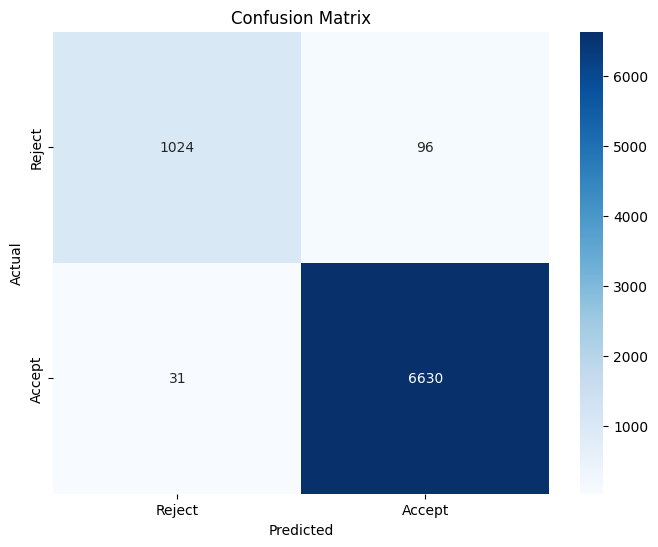

In [163]:
conf_matrix = confusion_matrix(y_test, y_pred_gbm)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Reject', 'Accept'],
            yticklabels=['Reject', 'Accept'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### So sánh kết quả giữa các mô hình

In [ ]:
metrics = {
    'Model': ['Decision Tree', 'Logistic Regression', 'Gradient Boosting'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_dt),
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_gbm),
    ],
    'Precision': [
        precision_score(y_test, y_pred_dt, average='weighted'),
        precision_score(y_test, y_pred_lr, average='weighted'),
        precision_score(y_test, y_pred_gbm, average='weighted'),
    ],
    'Recall': [
        recall_score(y_test, y_pred_dt, average='weighted'),
        recall_score(y_test, y_pred_lr, average='weighted'),
        recall_score(y_test, y_pred_gbm, average='weighted'),
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_dt, average='weighted'),
        f1_score(y_test, y_pred_lr, average='weighted'),
        f1_score(y_test, y_pred_gbm, average='weighted'),
    ],
    'AUC-ROC': [
        roc_auc_score(y_test, y_pred_dt),
        roc_auc_score(y_test, y_pred_lr),
        roc_auc_score(y_test, y_pred_gbm),
    ],
    'Train Time': [
        dt_train_time,
        lr_train_time,
        gbm_train_time,
    ],
}

metrics_df = pd.DataFrame(metrics)
display(metrics_df)

Model  Accuracy  Precision    Recall  F1 Score   AUC-ROC  \
0        Decision Tree  0.993036   0.993007  0.993036  0.993004  0.980469   
1  Logistic Regression  0.999842   0.999842  0.999842  0.999842  0.999909   
2    Gradient Boosting  0.997942   0.997947  0.997942  0.997936  0.992308   

   Train Time  
0    0.277485  
1    0.180520  
2    1.965021

**Nhận xét tổng quan:**

*  Cả 3 mô hình đều cho ra kết quả rất tốt mặc dù chưa hypertuning, cả 4 metric `accuracy`, `precision`, `recall` và `F1 score` đều trên 0.99 và chỉ có AUC của mô hình Decision Tree đạt dưới 0.99 - là 0.98. Điều này cho thấy các mô hình trên là phù hợp với bộ dữ liệu hiện tại, đồng thời ảnh hưởng của việc không cân bằng giữa 2 lớp cần phân loại gần như không có.
*  Dù có chênh lệch về metric giữa các mô hình nhưng chỉ rất nhỏ, trong khoảng 0.019 cho AUC và khoảng 0.007 cho các metric còn lại.
*  Nổi trội nhất có thể thấy là mô hình Logistic Regression với sự thời gian Train thấp nhất nhưng tất cả các metrics đều cao nhất trong cả 3 mô hình. Điều này giống với những gì ta kỳ vọng khi quan sát bộ dữ liệu ở trên (Bộ dữ liệu đã phân tách khá tốt nên có thể một phương pháp đơn giản, truyền thống cũng có thể đạt được kết quả tốt).

⇒ Ta sẽ chọn Logistic Regression là kiến trúc để thiết kế lại một mô hình mới với ít feature hơn, đơn giản hơn dựa trên các phân tích feature importance ở dưới. Đồng thời, sẽ hypertuning và tạo một script để dự doán các khách hàng mới trong tương lai.

## 5. Explainability

**Các biến từ mô hình Logistic Regression.**

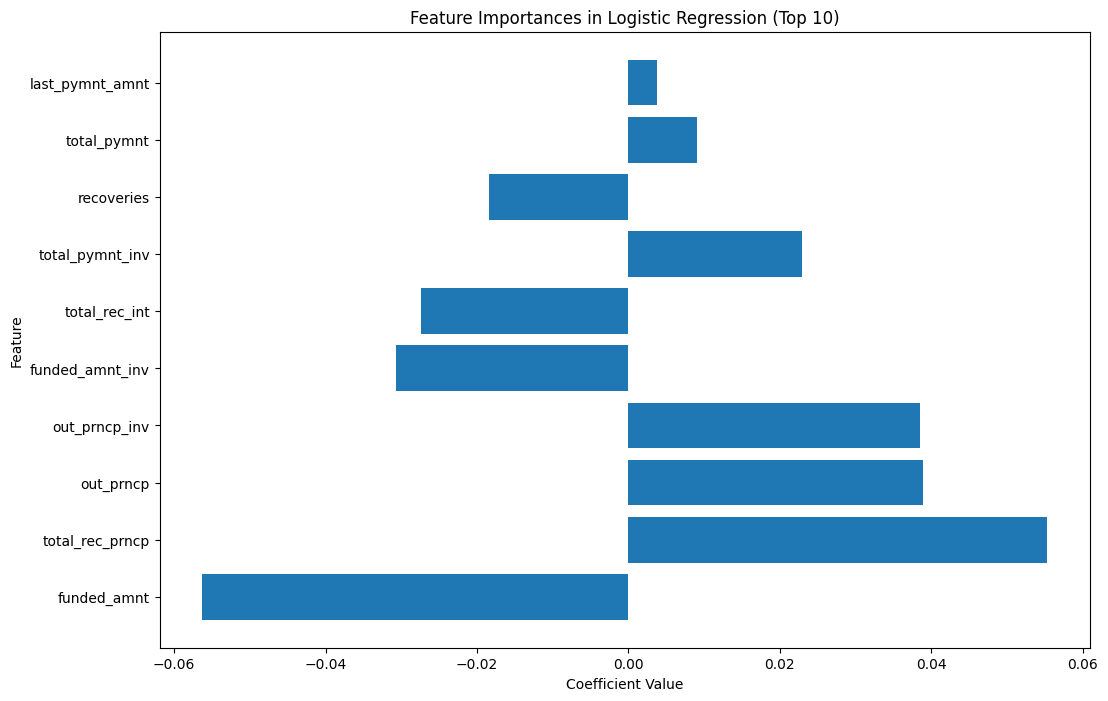

In [ ]:
coefficients = lr_model.coef_[0]  # Access coefficients for feature importance
feature_names = X_train.columns

feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients,
    'Odds Ratio': np.exp(coefficients)
})

# Sort by absolute value of coefficient to get the most important features
feature_importance['Abs Coefficient'] = np.abs(
    feature_importance['Coefficient'])
feature_importance_sorted = feature_importance.sort_values(
    by='Abs Coefficient', ascending=False)

# Plotting the feature importances (Coefficients)
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_sorted['Feature'].head(
    10), feature_importance_sorted['Coefficient'].head(10))
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importances in Logistic Regression (Top 10)')
plt.show()

**Các biến từ mô hình Decision Tree.**

In [ ]:
importances = dt_model.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame(
    {'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=True)

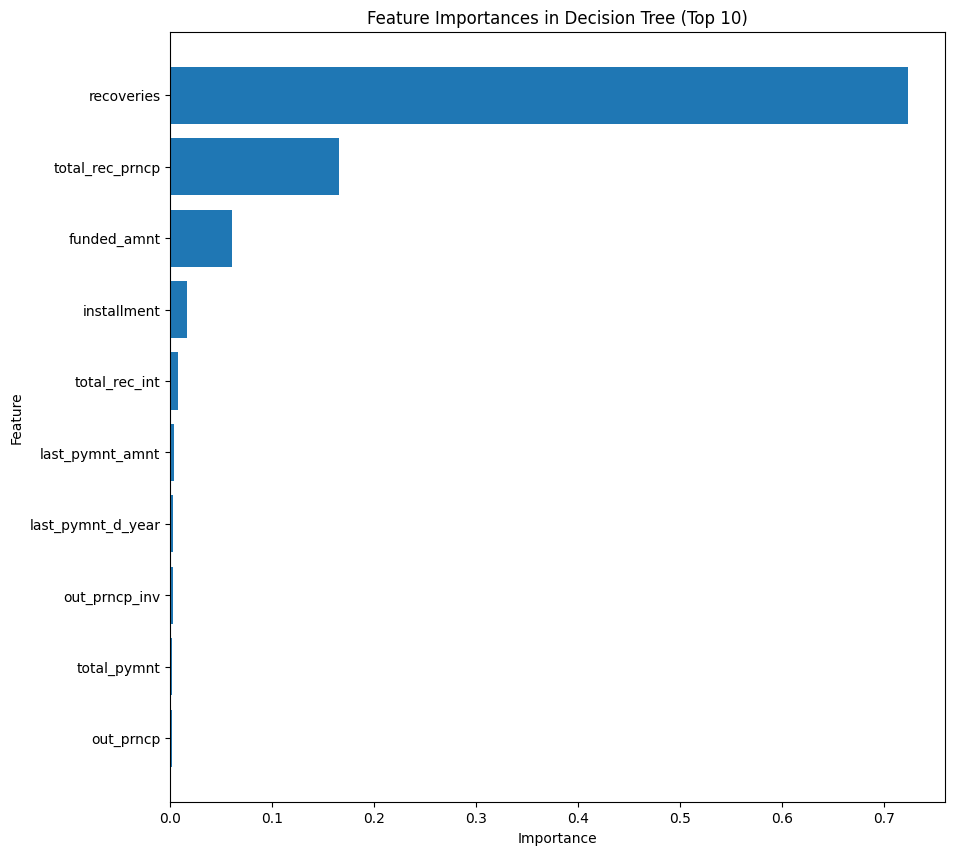

In [ ]:
plt.figure(figsize=(10, 10))
plt.barh(importance_df['Feature'].tail(10),
         importance_df['Importance'].tail(10))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Decision Tree (Top 10)')
plt.show()

In [ ]:
recoveries_accept = df['recoveries'][df['loan_status'] == 1]
recoveries_accept.value_counts()

recoveries
0.0    27254
Name: count, dtype: int64

In [ ]:
recoveries_reject = df['recoveries'][df['loan_status'] == 0]
recoveries_reject.value_counts()

recoveries
0.00       1090
11.29         4
16.50         3
14.61         3
12.09         3
           ... 
1366.13       1
311.57        1
17.53         1
222.17        1
304.20        1
Name: count, Length: 3125, dtype: int64

**Các biến từ mô hình Gradient Boosting.**

c:\Users\PC\anaconda3\envs\loan\lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


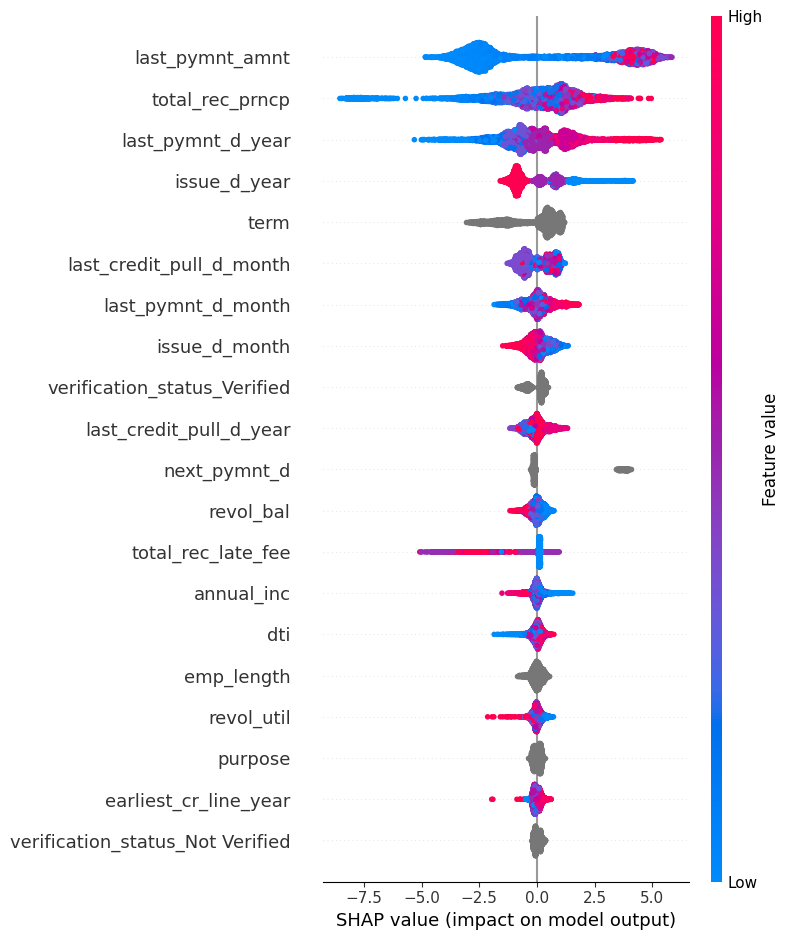

In [164]:
explainer = shap.TreeExplainer(gbm_model)
shap_values = explainer.shap_values(X_valid_gbm)

shap.summary_plot(shap_values, X_valid_gbm)

**Nhận xét tổng quan:**

*  Trong mô hình **Logistic Regression**, các biến có tác động lớn là:
    *  `funded_amnt`: Có hệ số âm lớn nhất, cho thấy khi số tiền được cấp (funded_amnt) càng cao, khả năng được duyệt khoản vay sẽ càng giảm. Điều này đúng với thực tế vì khoản vay càng lớn sẽ càng khó được cho vay.
    *  `total_rec_prncp`: Có hệ số dương mạnh, cho thấy khi số tiền gốc đã trả càng cao, khả năng được duyệt khoản vay sẽ càng tăng. Điều này đúng với thực tế vì người vay trả nợ càng nhiều thì uy tín của họ càng cao, tỉ lệ được cho vay tiếp càng cao.
    *  `out_prncp` và `out_prncp_inv`: Hai đặc trưng này tượng trưng cho số tiền gốc còn phải trả cho bên cho vay - cũng có hệ số dương, nghĩa là khi giá trị này tăng lên, khả năng xảy ra sự kiện sẽ tăng. Tuy nhiên, vì bộ dữ liệu này ghi nhận 2 giá trị này bằng 0 khi khách hàng `Charged Off` (không trả nợ) - giống với khi khách hàng `Fully Paid` (trả hết nợ) - và chỉ có khách hàng nào đang trả nợ `Current` mới có 2 giá trị này lớn hơn 0. Điều này dẫn tới tuy có hệ số cao nhưng 2 biến này chỉ dự đoán được các khách hàng `Current`, nếu bên ngoài tệp khách hàng đó 2 biến này sẽ không có ích.
    *  Các biến `funded_amnt_inv`, `total_rec_int`, `total_pymnt_inv` và `recoveries` có hệ số tương ứng giảm dần, tuy không lớn nhưng cũng hơn rất nhiều so với hệ số của các biến trở về sau.
*  Trong mô hình **Decision Tree**, các biến có tác động lớn là:
    *  `recoveries`: Là đặc trưng quan trọng nhất, có mức độ ảnh hưởng lớn hơn nhiều so với các đặc trưng còn lại. Tuy nhiên, biến này là số tiền thu hồi được sau khi xóa nợ (hay số tiền bị đòi nợ sau khi trốn nợ), tức là nếu biến này có giá trị dương thì chắc chắn khách hàng này đã trốn nợ - `Charged Off`, còn nếu biến này có giá trị bằng 0 thì tỉ lệ rất cao là khách hàng đã trả nợ `Fully Paid` hoặc đang trả nợ `Current`. Minh chứng là có tới 33477 giá trị 0 và là giá trị duy nhất ở lớp `Accept` và chỉ có 1347 giá trị 0 ở lớp `Reject`.
    *  `total_rec_prncp`: Là đặc trưng quan trọng thứ hai. Gợi ý rằng tổng số tiền gốc đã trả (total_rec_prncp) cũng là một yếu tố dự đoán mạnh. Điều này đúng với thực tế và giống với của mô hình Logistic Regression.
    *  `funded_amnt`: Là đặc trưng quan trọng thứ ba. Cho thấy tổng số tiền đã được cấp (funded_amnt) có ảnh hưởng đáng kể đến dự đoán. Điều này đúng với thực tế và giống với của mô hình Logistic Regression.
*  Trong mô hình **Gradient Boosting**, các biến có tác động lớn là:
    *  `total_rec_prncp`: Là đặc trưng quan trọng nhất. Các giá trị SHAP màu đỏ đều là giá trị dương, tức là số tiền gốc đã trả càng lớn thì tỉ lệ duyệt đơn xin vay càng tăng. Điều này là đúng với thực tế và giống với phân tích ở phần Logistic Regression.
    *  `recoveries`: Quan trọng thứ hai. Các giá trị SHAP màu đỏ đều là giá trị âm, tức là số tiền thu hồi được sau khi xóa nợ càng lớn thì tỉ lệ duyệt đơn xin vay càng giảm. Điều này là đúng và phù hợp với phân tích ở phần Decision Tree.
    *  `funded_amnt`: Là đặc trưng quan trọng thứ ba. Các giá trị SHAP màu đỏ đều là giá trị âm, tức là số tiền được cấp/xin vay càng lớn thì tỉ lệ duyệt đơn xin vay càng giảm. Điều này là đúng với thực tế và giống với phân tích ở phần Logistic Regression.

Nhìn chung, các biến có tác động lớn nhất xuất hiện trong cả 3 mô hình là `funded_amnt` (số tiền được cấp/xin vay) và `total_rec_prncp` (số tiền gốc đã trả). Trong thực tế, hai yếu tố trên cũng đóng một phần quan trọng trong quyết định cho vay nên ta có thể coi các mô hình đã huấn luyện cho ra kết quả hợp lý với thực tiễn, có thể giải thích được.

Ngoài ra, để xây dựng một mô hình mới đơn giản hơn, ở trên ta đã chọn mô hình Logistic Regression nên bây giờ ta sẽ chọn 8 biến có tác động lớn tới mô hình Logistic Regression để huấn luyện mô hình mới, gồm: `funded_amnt`, `total_rec_prncp`, `out_prncp`, `out_prncp_inv`, `funded_amnt_inv`, `total_rec_int`, `total_pymnt_inv` và `recoveries`.

## 6. Xây dựng mô hình mới

**Tạo bộ dữ liệu mới chỉ gồm 8 biến đặc trưng đã chọn và 1 biến mục tiêu.**

In [ ]:
new_df = pd.DataFrame()

for feature in feature_importance_sorted['Feature'].head(8):
    new_df[feature] = df[feature]

new_df['loan_status'] = df['loan_status']

In [ ]:
new_df

funded_amnt  total_rec_prncp  out_prncp  out_prncp_inv  \
3            10000         10000.00        0.0            0.0   
5             5000          5000.00        0.0            0.0   
6             7000          6985.61        0.0            0.0   
7             3000          3000.00        0.0            0.0   
8             5600           162.02        0.0            0.0   
...            ...              ...        ...            ...   
39562         4800          4800.00        0.0            0.0   
39573         7000          7000.00        0.0            0.0   
39623         9000          1496.83        0.0            0.0   
39666        15450          8688.59        0.0            0.0   
39680         3000          3000.00        0.0            0.0   

       funded_amnt_inv  total_rec_int  total_pymnt_inv  recoveries  \
3              10000.0        2214.92         12231.89        0.00   
5               5000.0         632.21          5632.21        0.00   
6               7000.0        3125.23         10110.84        0.00   
7               3000.0         939.14          3939.14        0.00   
8               5600.0         294.94           646.02      189.06   
...                ...            ...              ...         ...   
39562           1100.0         334.09          1176.56        0.00   
39573           1000.0        1174.02          1167.72        0.00   
39623            700.0         609.26           311.64     1909.87   
39666            600.0        2659.96           451.73      304.20   
39680            525.0         579.66           626.44        0.00   

       loan_status  
3                1  
5                1  
6                1  
7                1  
8                0  
...            ...  
39562            1  
39573            1  
39623            0  
39666            0  
39680            1  

[31587 rows x 9 columns]

**Train-Test split và chuẩn hóa.**

In [ ]:
X_new = new_df.drop(columns=['loan_status'])
y_new = new_df['loan_status']

In [ ]:
TRAIN_SIZE = 0.8

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_new, y_new, train_size=TRAIN_SIZE, random_state=0)

In [ ]:
X_train_new.shape, X_test_new.shape

((25269, 8), (6318, 8))

In [ ]:
scaler_new = StandardScaler()

X_train_new = scaler_new.fit_transform(X_train_new)
X_test_new = scaler_new.transform(X_test_new)

**Huấn luyện và hypertuning cho mô hình.**

In [ ]:
model = LogisticRegression()

In [ ]:
lr_param_grid = {
    'max_iter': [50, 100, 200],
    'C': [0.1, 0.5, 1, 5, 10],
    'solver': ['lbfgs', 'liblinear', 'saga']
}

grid_search = GridSearchCV(
    estimator=model, param_grid=lr_param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_new, y_train_new)

# In ra các hyperparameters tốt nhất
print(f"Best Parameters for Logistic Regression: {grid_search.best_params_}")

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best Parameters for Logistic Regression: {'C': 10, 'max_iter': 50, 'solver': 'liblinear'}


**Đánh giá mô hình mới.**

In [ ]:
best_model = grid_search.best_estimator_  # Lưu lại mô hình có performance tốt nhất
y_pred = best_model.predict(X_test_new)

In [ ]:
auc_score = roc_auc_score(y_test, y_pred)
print("AUC-ROC (Tuned Logistic Regression):", auc_score)

AUC-ROC (Tuned Logistic Regression): 0.9905325443786982


In [ ]:
print("Tuned Logistic Regression - Classification Report:")
print(classification_report(y_test, y_pred))

Tuned Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       845
           1       1.00      1.00      1.00      5473

    accuracy                           1.00      6318
   macro avg       1.00      0.99      0.99      6318
weighted avg       1.00      1.00      1.00      6318



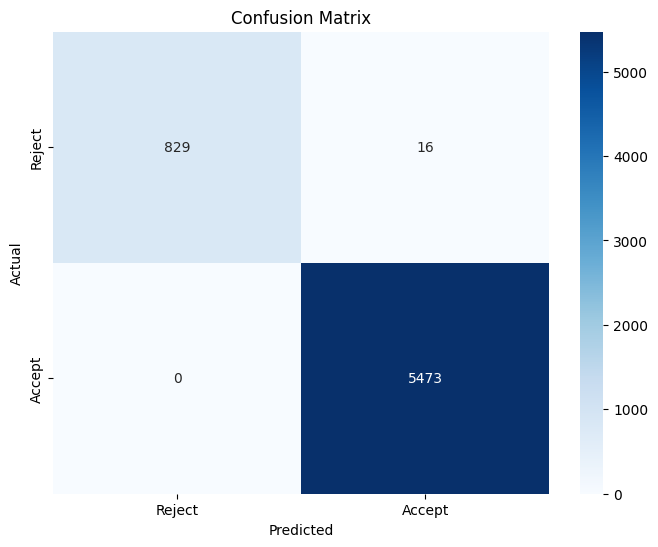

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Reject', 'Accept'],
            yticklabels=['Reject', 'Accept'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**So sánh mô hình gốc và mô hình đã đơn giản hóa.**

In [ ]:
metrics = {
    'Model': ['Logistic Regression', 'Tuned Logistic Regression'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred),
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr, average='weighted'),
        precision_score(y_test, y_pred, average='weighted'),
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr, average='weighted'),
        recall_score(y_test, y_pred, average='weighted'),
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_lr, average='weighted'),
        f1_score(y_test, y_pred, average='weighted'),
    ],
    'AUC-ROC': [
        roc_auc_score(y_test, y_pred_lr),
        roc_auc_score(y_test, y_pred),
    ],
}

metrics_df = pd.DataFrame(metrics)
display(metrics_df)

Model  Accuracy  Precision    Recall  F1 Score  \
0        Logistic Regression  0.999842   0.999842  0.999842  0.999842   
1  Tuned Logistic Regression  0.997468   0.997475  0.997468  0.997457   

    AUC-ROC  
0  0.999909  
1  0.990533

**Nhận xét nhanh:**

*  Với chỉ 8 biến đặc trưng, sau khi hypertuning thì các metric của mô hình Logistic Regression mới chỉ giảm khoảng 0.009 ở AUC và 0.002 ở các metric còn lại.

⇒ Với mô hình được đơn giản hóa từ 53 biến đặc trưng còn 8 biến đặc trưng nhưng hiệu suất giảm rất nhỏ thì đây là một sự thành công và ta có thể lưu lại mô hình mới này để sử dụng cho sau này.

**Lưu lại mô hình và scaler để sử dụng sau.**

In [ ]:
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler_new, file)

In [ ]:
model_pkl_file = "loan_classifier_model.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(grid_search.best_estimator_, file)